In [1]:
import pandas as pd
from datetime import datetime, date, time, timedelta
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import mlflow
import sys
import os
# Get the parent directory and add it to sys.path
parent_dir = os.path.abspath("..")
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm


import pmdarima as pm
from functions_anton.functions_models import find_dominant_stable_hours

# Adjusted plotting function

In [2]:
def plot_forecast(df_train, df_test, station_uuid = None, df_train_prediction=None, df_test_prediction=None, train_dates=None, test_dates=None, train_dates_plot=None, test_dates_plot=None):
    plt.figure(figsize=(15, 6))
    
    train_mask = (df_train['date'] >= train_dates[0]) & (df_train['date'] <= train_dates[1]) if train_dates else slice(None)
    test_mask = (df_test['date'] >= test_dates[0]) & (df_test['date'] <= test_dates[1]) if test_dates else slice(None)


    if station_uuid is not None:
        df_train = df_train[df_train['station_uuid'] == station_uuid]
        df_test = df_test[df_test['station_uuid'] == station_uuid]

    if df_train_prediction is not None:
        df_train_prediction = df_train_prediction[(df_train_prediction['date'] >= train_dates[0]) & (df_train_prediction['date'] <= train_dates[1])]
        #plt.plot(df_train_prediction['date'], df_train_prediction['e5'], label='Train Prediction', color='green', linestyle='--', linewidth=2, drawstyle='steps-post')

    if df_test_prediction is not None:
        df_test_prediction = df_test_prediction[(df_test_prediction['date'] >= test_dates[0]) & (df_test_prediction['date'] <= test_dates[1])]
        plt.plot(df_test_prediction['date'], df_test_prediction['e5'], label='Test Prediction', color='red', linestyle='--', linewidth=2, drawstyle='steps-post')

        # --- Error Calculation and Display ---
        df_merged = df_test.merge(df_test_prediction, on='date', suffixes=('_actual', '_pred'))
        df_merged = df_merged.sort_values('date').reset_index(drop=True)

        mae_dict = {}
        rmse_dict = {}
        r2_dict = {}

        for i, days in enumerate([1, 3, 7]):
            time_cutoff = df_merged['date'].min() + timedelta(days=days)
            df_subset = df_merged[df_merged['date'] < time_cutoff]

            if not df_subset.empty:
                mae = mean_absolute_error(df_subset['e5_actual'], df_subset['e5_pred'])
                rmse = np.sqrt(mean_squared_error(df_subset['e5_actual'], df_subset['e5_pred']))
                r2 = r2_score(df_subset['e5_actual'], df_subset['e5_pred'])
                mae_dict[days] = mae
                rmse_dict[days] = rmse
                r2_dict[days] = r2

                print(f"{days}-Day MAE in cent: {mae *100:.4f}")
                print(f"{days}-Day RMSE in cent: {rmse *100:.4f}")
                print(f"{days}-Day r2-score: {r2:.4f}")
                #plt.text(0.01, 0.95 - 0.05 * i, f'{days}-day MAE in cent: {mae*100:.4f}', 
                         #transform=plt.gca().transAxes, fontsize=12, 
                         #bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.7))
    
    plt.plot(df_train.loc[train_mask, 'date'], df_train.loc[train_mask, 'e5'], label='Train Actual', color='blue', linewidth=2, drawstyle='steps-post', alpha=0.7)
    plt.plot(df_test.loc[test_mask, 'date'], df_test.loc[test_mask, 'e5'], label='Test Actual', color='orange', linewidth=2, drawstyle='steps-post', alpha=0.7)

    plt.legend(fontsize=12, title_fontsize=14, loc='upper left', frameon=True, fancybox=True, shadow=True)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title('E5 Price: Actual vs Prediction', fontsize=16)
    plt.xlabel('date', fontsize=14)
    plt.ylabel('E5 price', fontsize=14)
    plt.tight_layout(pad=2)
    plt.gca().set_facecolor('#f7f7fa')
    plt.gcf().patch.set_facecolor('#eaeaf2')
    plt.grid(True, which='both', axis='y', linestyle=':', linewidth=0.7)
    plt.grid(True, which='both', axis='x', linestyle=':', linewidth=0.7)
    plt.xlim(pd.to_datetime(train_dates_plot[0]),pd.to_datetime(test_dates_plot[1]))
    plt.savefig("prediction.png")
    mlflow.log_artifact("prediction.png")
    plt.show()

    # After the loop, you have:
    mae_1_day = mae_dict.get(1)
    mae_3_day = mae_dict.get(3)
    mae_7_day = mae_dict.get(7)
    rmse_1_day = rmse_dict.get(1)
    rmse_3_day = rmse_dict.get(3)
    rmse_7_day = rmse_dict.get(7)
    r2_1_day = r2_dict.get(1)
    r2_3_day = r2_dict.get(3)
    r2_7_day = r2_dict.get(7)

    return mae_1_day, mae_3_day, mae_7_day, rmse_1_day, rmse_3_day, rmse_7_day, r2_1_day, r2_3_day, r2_7_day





    

# MLFlow

In [3]:
# to be sure that no other run from another notebook is active
mlflow.end_run() 
# Get absolute path for MLflow directory
mlflow_dir = os.path.abspath("../data/mlflow")

# Create fresh directory
os.makedirs(mlflow_dir, exist_ok=True)

# Basic MLflow config - use file protocol with absolute path 
mlflow.set_tracking_uri(f"file://{os.path.abspath(mlflow_dir)}")

# Set up FuelProphet experiment
try:
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    experiment_name = f"FuelProphet_SARIMA_Anton_Loop_{timestamp}"
    experiment = mlflow.get_experiment_by_name(experiment_name)
    
    if experiment is None:
        # Only create if it doesn't exist
        mlflow.create_experiment(experiment_name)
        
    # Set as active experiment
    mlflow.set_experiment(experiment_name)
    print("FuelProphet experiment setup successful!")
    
except Exception as e:
    print(f"MLflow error: {e}")

Traceback (most recent call last):
  File "/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 347, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 445, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 1588, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/mlflow/store/trac

FuelProphet experiment setup successful!


# Data

In [4]:
# Train
df01_train = pd.read_parquet('../data/parquet_4_testing_2/train_01.parquet')
df02_train = pd.read_parquet('../data/parquet_4_testing_2/train_02.parquet')
df03_train = pd.read_parquet('../data/parquet_4_testing_2/train_03.parquet')
df04_train = pd.read_parquet('../data/parquet_4_testing_2/train_04.parquet')
df05_train = pd.read_parquet('../data/parquet_4_testing_2/train_05.parquet')
df06_train = pd.read_parquet('../data/parquet_4_testing_2/train_06.parquet')
df07_train = pd.read_parquet('../data/parquet_4_testing_2/train_07.parquet')
df08_train = pd.read_parquet('../data/parquet_4_testing_2/train_08.parquet')
df09_train = pd.read_parquet('../data/parquet_4_testing_2/train_09.parquet')
df10_train = pd.read_parquet('../data/parquet_4_testing_2/train_10.parquet')
df11_train = pd.read_parquet('../data/parquet_4_testing_2/train_11.parquet')
df12_train = pd.read_parquet('../data/parquet_4_testing_2/train_12.parquet')
df13_train = pd.read_parquet('../data/parquet_4_testing_2/train_13.parquet')
df14_train = pd.read_parquet('../data/parquet_4_testing_2/train_14.parquet')
df15_train = pd.read_parquet('../data/parquet_4_testing_2/train_15.parquet')
df16_train = pd.read_parquet('../data/parquet_4_testing_2/train_16.parquet')
df17_train = pd.read_parquet('../data/parquet_4_testing_2/train_17.parquet')
df18_train = pd.read_parquet('../data/parquet_4_testing_2/train_18.parquet')
df19_train = pd.read_parquet('../data/parquet_4_testing_2/train_19.parquet')
df20_train = pd.read_parquet('../data/parquet_4_testing_2/train_20.parquet')
df21_train = pd.read_parquet('../data/parquet_4_testing_2/train_21.parquet')
df22_train = pd.read_parquet('../data/parquet_4_testing_2/train_22.parquet')
df23_train = pd.read_parquet('../data/parquet_4_testing_2/train_23.parquet')
df24_train = pd.read_parquet('../data/parquet_4_testing_2/train_24.parquet')
df25_train = pd.read_parquet('../data/parquet_4_testing_2/train_25.parquet')
df26_train = pd.read_parquet('../data/parquet_4_testing_2/train_26.parquet')
df27_train = pd.read_parquet('../data/parquet_4_testing_2/train_27.parquet')
df28_train = pd.read_parquet('../data/parquet_4_testing_2/train_28.parquet')
df29_train = pd.read_parquet('../data/parquet_4_testing_2/train_29.parquet')
df30_train = pd.read_parquet('../data/parquet_4_testing_2/train_30.parquet')

# Test
df01_test = pd.read_parquet('../data/parquet_4_testing_2/test_01.parquet')
df02_test = pd.read_parquet('../data/parquet_4_testing_2/test_02.parquet')
df03_test = pd.read_parquet('../data/parquet_4_testing_2/test_03.parquet')
df04_test = pd.read_parquet('../data/parquet_4_testing_2/test_04.parquet')
df05_test = pd.read_parquet('../data/parquet_4_testing_2/test_05.parquet')
df06_test = pd.read_parquet('../data/parquet_4_testing_2/test_06.parquet')
df07_test = pd.read_parquet('../data/parquet_4_testing_2/test_07.parquet')
df08_test = pd.read_parquet('../data/parquet_4_testing_2/test_08.parquet')
df09_test = pd.read_parquet('../data/parquet_4_testing_2/test_09.parquet')
df10_test = pd.read_parquet('../data/parquet_4_testing_2/test_10.parquet')
df11_test = pd.read_parquet('../data/parquet_4_testing_2/test_11.parquet')
df12_test = pd.read_parquet('../data/parquet_4_testing_2/test_12.parquet')
df13_test = pd.read_parquet('../data/parquet_4_testing_2/test_13.parquet')
df14_test = pd.read_parquet('../data/parquet_4_testing_2/test_14.parquet')
df15_test = pd.read_parquet('../data/parquet_4_testing_2/test_15.parquet')
df16_test = pd.read_parquet('../data/parquet_4_testing_2/test_16.parquet')
df17_test = pd.read_parquet('../data/parquet_4_testing_2/test_17.parquet')
df18_test = pd.read_parquet('../data/parquet_4_testing_2/test_18.parquet')
df19_test = pd.read_parquet('../data/parquet_4_testing_2/test_19.parquet')
df20_test = pd.read_parquet('../data/parquet_4_testing_2/test_20.parquet')
df21_test = pd.read_parquet('../data/parquet_4_testing_2/test_21.parquet')
df22_test = pd.read_parquet('../data/parquet_4_testing_2/test_22.parquet')
df23_test = pd.read_parquet('../data/parquet_4_testing_2/test_23.parquet')
df24_test = pd.read_parquet('../data/parquet_4_testing_2/test_24.parquet')
df25_test = pd.read_parquet('../data/parquet_4_testing_2/test_25.parquet')
df26_test = pd.read_parquet('../data/parquet_4_testing_2/test_26.parquet')
df27_test = pd.read_parquet('../data/parquet_4_testing_2/test_27.parquet')
df28_test = pd.read_parquet('../data/parquet_4_testing_2/test_28.parquet')
df29_test = pd.read_parquet('../data/parquet_4_testing_2/test_29.parquet')
df30_test = pd.read_parquet('../data/parquet_4_testing_2/test_30.parquet')

In [5]:
datasets = {
    'df01': (df01_train, df01_test),
    'df02': (df02_train, df02_test),
    'df03': (df03_train, df03_test),
    'df04': (df04_train, df04_test),
    'df05': (df05_train, df05_test),
    'df06': (df06_train, df06_test),
    'df07': (df07_train, df07_test),
    'df08': (df08_train, df08_test),
    'df09': (df09_train, df09_test),
    'df10': (df10_train, df10_test),
    'df11': (df11_train, df11_test),
    'df12': (df12_train, df12_test),
    'df13': (df13_train, df13_test),
    'df14': (df14_train, df14_test),
    'df15': (df15_train, df15_test),
    'df16': (df16_train, df16_test),
    'df17': (df17_train, df17_test),
    'df18': (df18_train, df18_test),
    'df19': (df19_train, df19_test),
    'df20': (df20_train, df20_test),
    'df21': (df21_train, df21_test),
    'df22': (df22_train, df22_test),
    'df23': (df23_train, df23_test),
    'df24': (df24_train, df24_test),
    'df25': (df25_train, df25_test),
    'df26': (df26_train, df26_test),
    'df27': (df27_train, df27_test),
    'df28': (df28_train, df28_test),
    'df29': (df29_train, df29_test),
    'df30': (df30_train, df30_test)
}

# Training


Processing dataset: df01
Fitting SARIMA model with order=(1, 0, 0) and seasonal_order=(0, 1, 0, 144)...
1-Day MAE in cent: 3.6631
1-Day RMSE in cent: 4.3896
1-Day r2-score: -2.5828
3-Day MAE in cent: 3.5793
3-Day RMSE in cent: 4.1682
3-Day r2-score: -2.4284
7-Day MAE in cent: 3.1501
7-Day RMSE in cent: 3.8710
7-Day r2-score: -1.3586


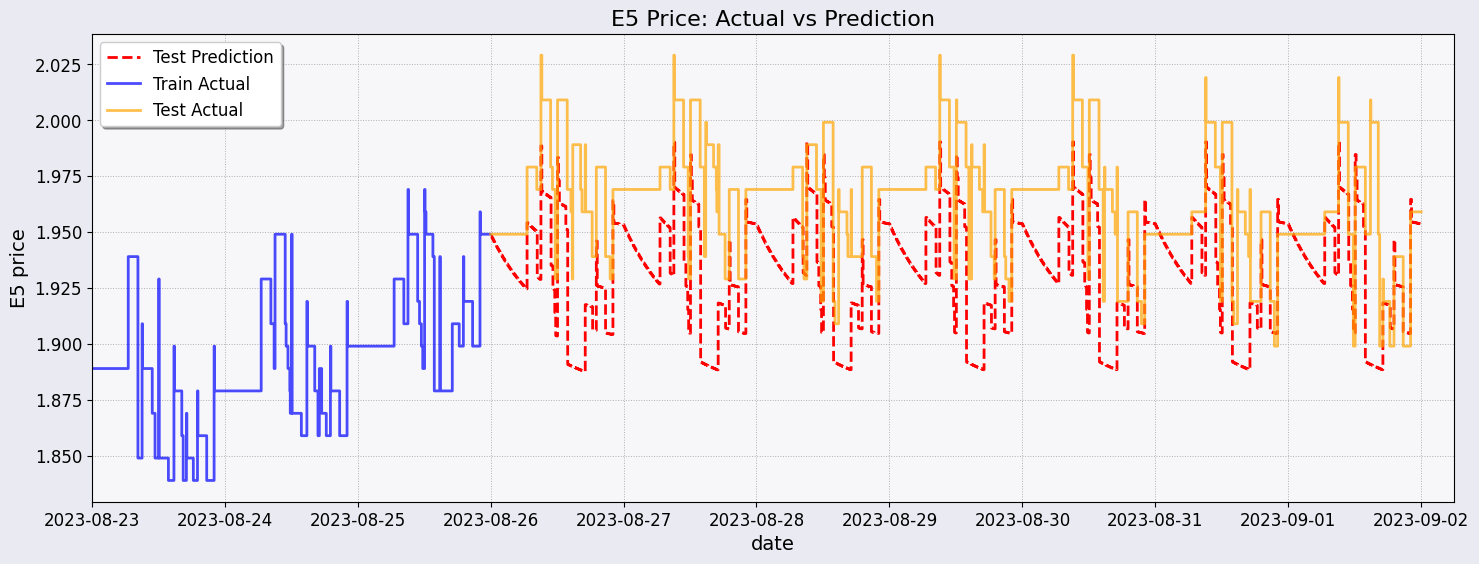

Successfully processed df01

Processing dataset: df02
Fitting SARIMA model with order=(1, 0, 0) and seasonal_order=(0, 1, 0, 144)...
1-Day MAE in cent: 2.6411
1-Day RMSE in cent: 3.4151
1-Day r2-score: -0.3106
3-Day MAE in cent: 2.3308
3-Day RMSE in cent: 3.2615
3-Day r2-score: -0.1225
7-Day MAE in cent: 1.9549
7-Day RMSE in cent: 2.8338
7-Day r2-score: 0.2589


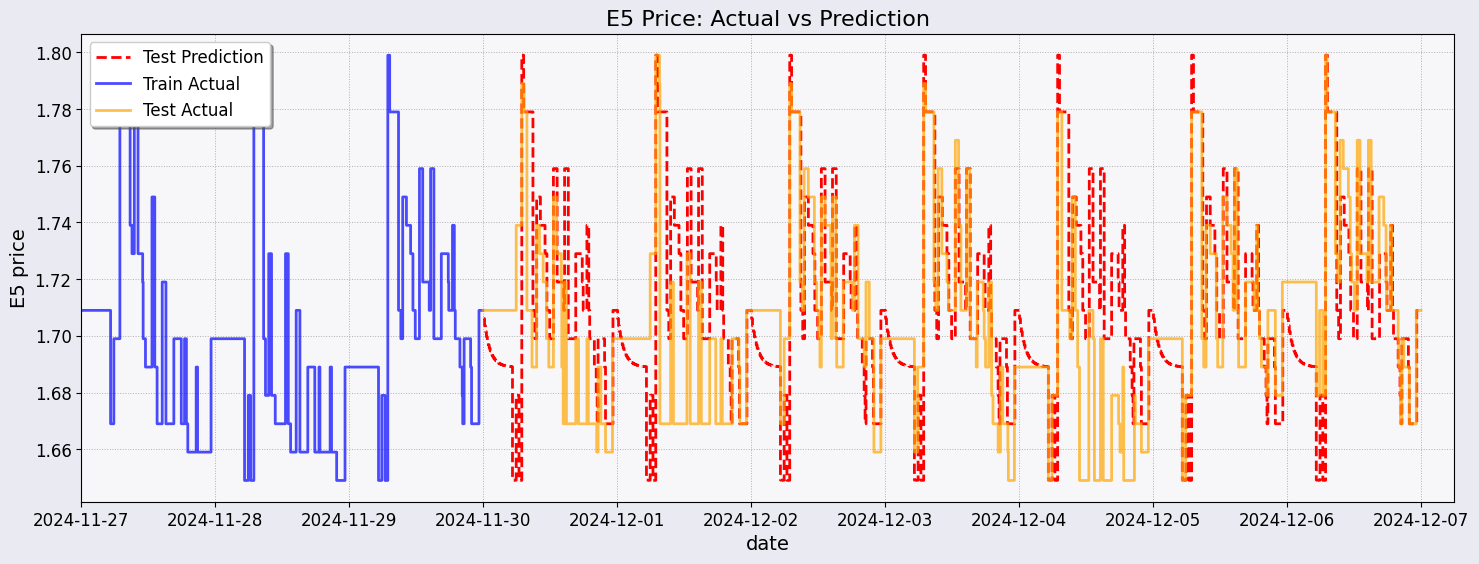

Successfully processed df02

Processing dataset: df03
Fitting SARIMA model with order=(1, 0, 0) and seasonal_order=(0, 1, 0, 144)...
1-Day MAE in cent: 1.1682
1-Day RMSE in cent: 1.6752
1-Day r2-score: 0.6838
3-Day MAE in cent: 1.6158
3-Day RMSE in cent: 2.3852
3-Day r2-score: 0.4533
7-Day MAE in cent: 2.3950
7-Day RMSE in cent: 3.0974
7-Day r2-score: 0.3387


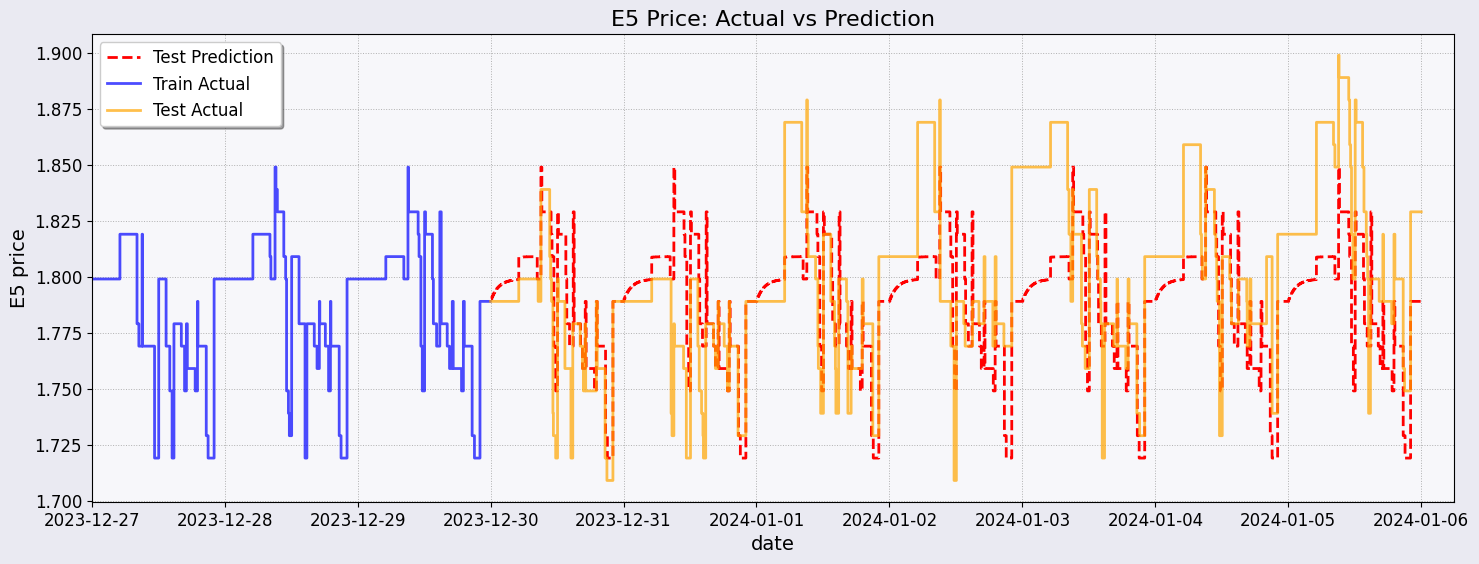

Successfully processed df03

Processing dataset: df04
Fitting SARIMA model with order=(1, 0, 0) and seasonal_order=(0, 1, 0, 144)...
1-Day MAE in cent: 2.0433
1-Day RMSE in cent: 2.8971
1-Day r2-score: -0.3227
3-Day MAE in cent: 1.4433
3-Day RMSE in cent: 2.3106
3-Day r2-score: 0.3232
7-Day MAE in cent: 1.6563
7-Day RMSE in cent: 2.5852
7-Day r2-score: 0.3050


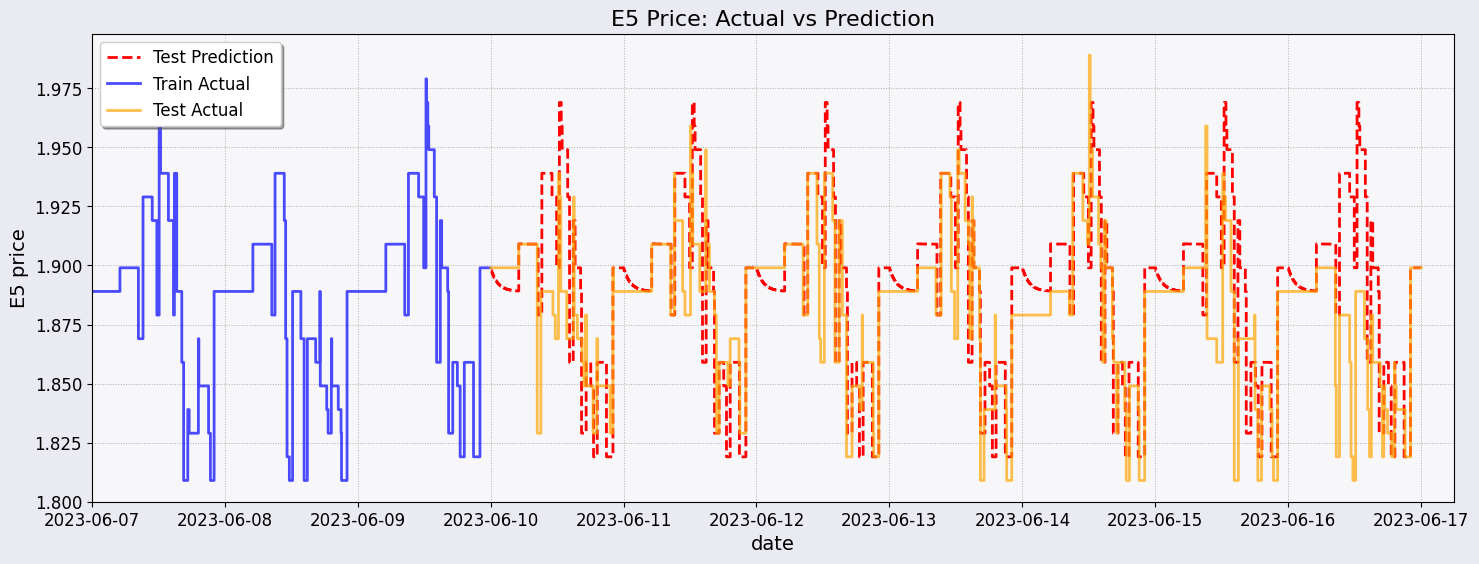

Successfully processed df04

Processing dataset: df05
Fitting SARIMA model with order=(1, 0, 0) and seasonal_order=(0, 1, 0, 144)...
1-Day MAE in cent: 1.5056
1-Day RMSE in cent: 1.8825
1-Day r2-score: 0.5121
3-Day MAE in cent: 3.9530
3-Day RMSE in cent: 5.4838
3-Day r2-score: -0.3486
7-Day MAE in cent: 3.0771
7-Day RMSE in cent: 4.2714
7-Day r2-score: -0.1375


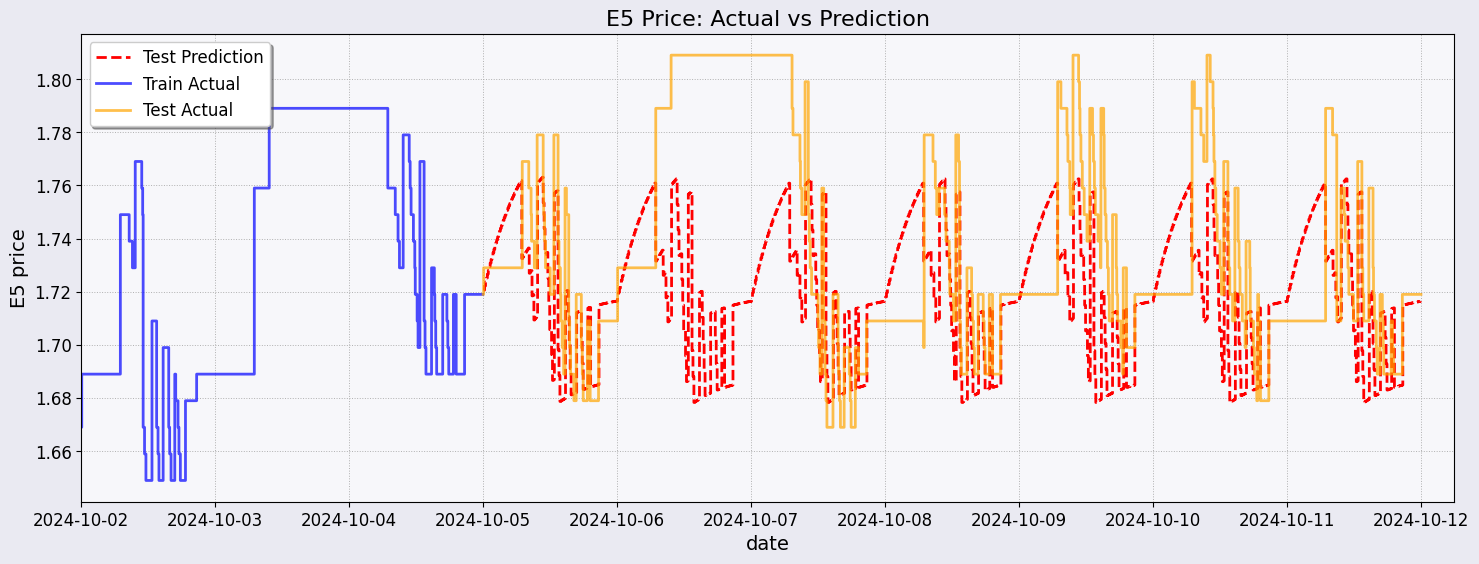

Successfully processed df05

Processing dataset: df06
Fitting SARIMA model with order=(1, 0, 0) and seasonal_order=(0, 1, 0, 144)...
1-Day MAE in cent: 0.6804
1-Day RMSE in cent: 1.0469
1-Day r2-score: 0.9357
3-Day MAE in cent: 1.1449
3-Day RMSE in cent: 2.3959
3-Day r2-score: 0.6479
7-Day MAE in cent: 1.1449
7-Day RMSE in cent: 2.3959
7-Day r2-score: 0.6479


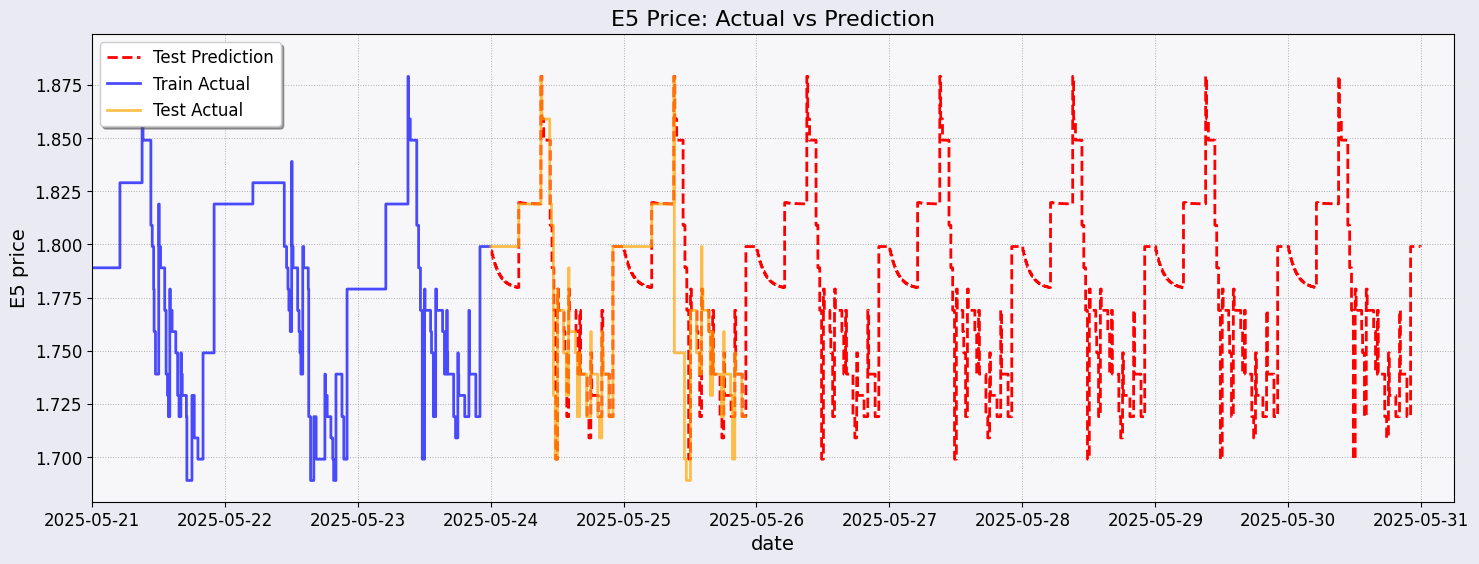

Successfully processed df06

Processing dataset: df07
Fitting SARIMA model with order=(1, 0, 0) and seasonal_order=(0, 1, 0, 144)...
1-Day MAE in cent: 0.8611
1-Day RMSE in cent: 1.6116
1-Day r2-score: 0.6739
3-Day MAE in cent: 1.0579
3-Day RMSE in cent: 1.8690
3-Day r2-score: 0.6536
7-Day MAE in cent: 1.1200
7-Day RMSE in cent: 1.6935
7-Day r2-score: 0.6829


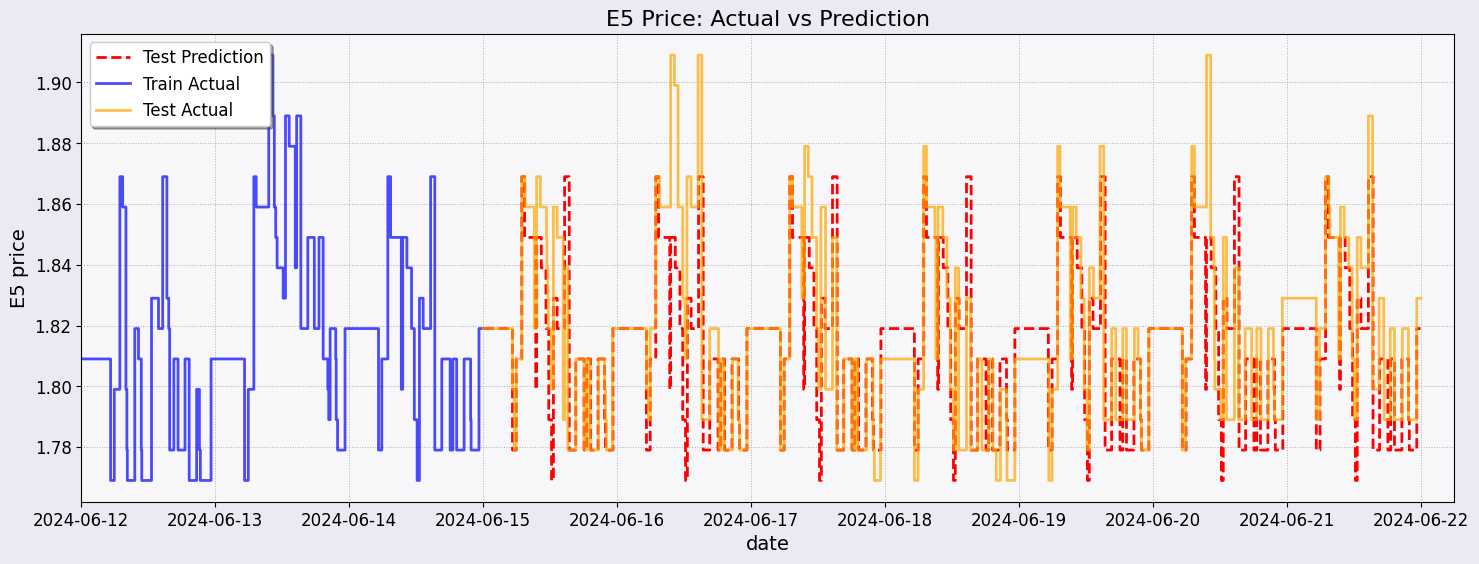

Successfully processed df07

Processing dataset: df08
Fitting SARIMA model with order=(1, 0, 0) and seasonal_order=(0, 1, 0, 144)...
1-Day MAE in cent: 1.5958
1-Day RMSE in cent: 2.4921
1-Day r2-score: 0.3060
3-Day MAE in cent: 1.9361
3-Day RMSE in cent: 2.7376
3-Day r2-score: 0.1901
7-Day MAE in cent: 2.0157
7-Day RMSE in cent: 2.9596
7-Day r2-score: 0.3472


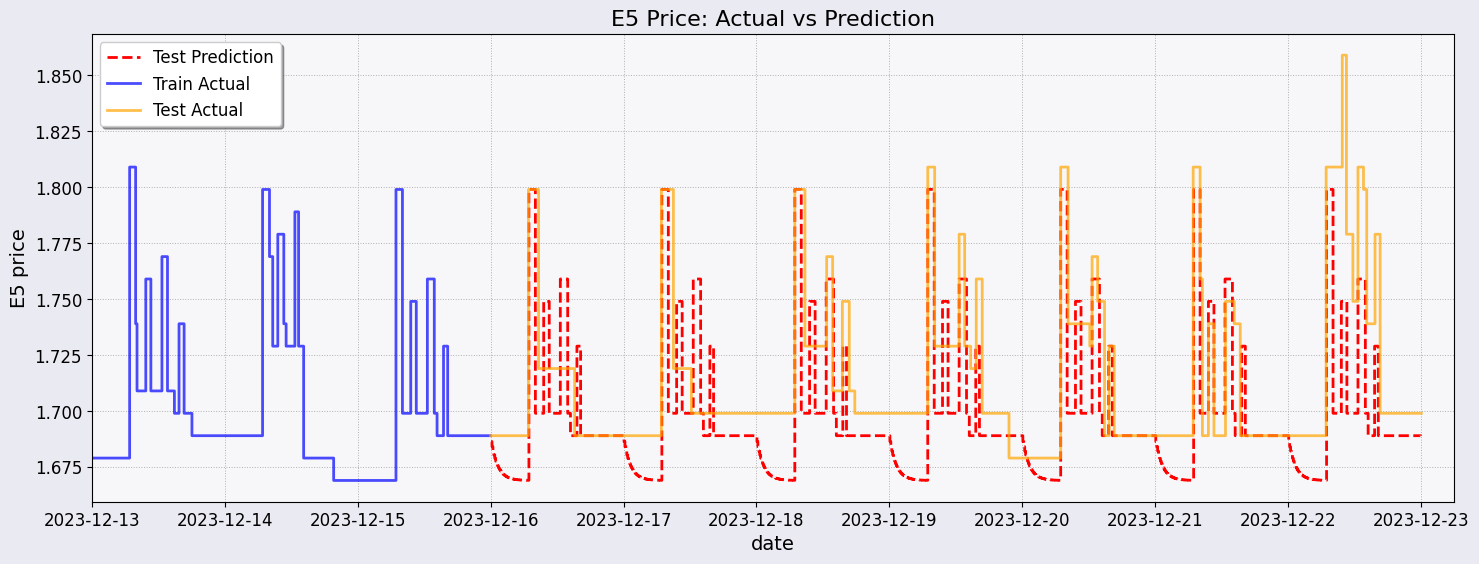

Successfully processed df08

Processing dataset: df09
Fitting SARIMA model with order=(1, 0, 0) and seasonal_order=(0, 1, 0, 144)...
1-Day MAE in cent: 0.7618
1-Day RMSE in cent: 1.0334
1-Day r2-score: 0.8670
3-Day MAE in cent: 0.5751
3-Day RMSE in cent: 1.0281
3-Day r2-score: 0.8760
7-Day MAE in cent: 1.6122
7-Day RMSE in cent: 2.4789
7-Day r2-score: 0.2667


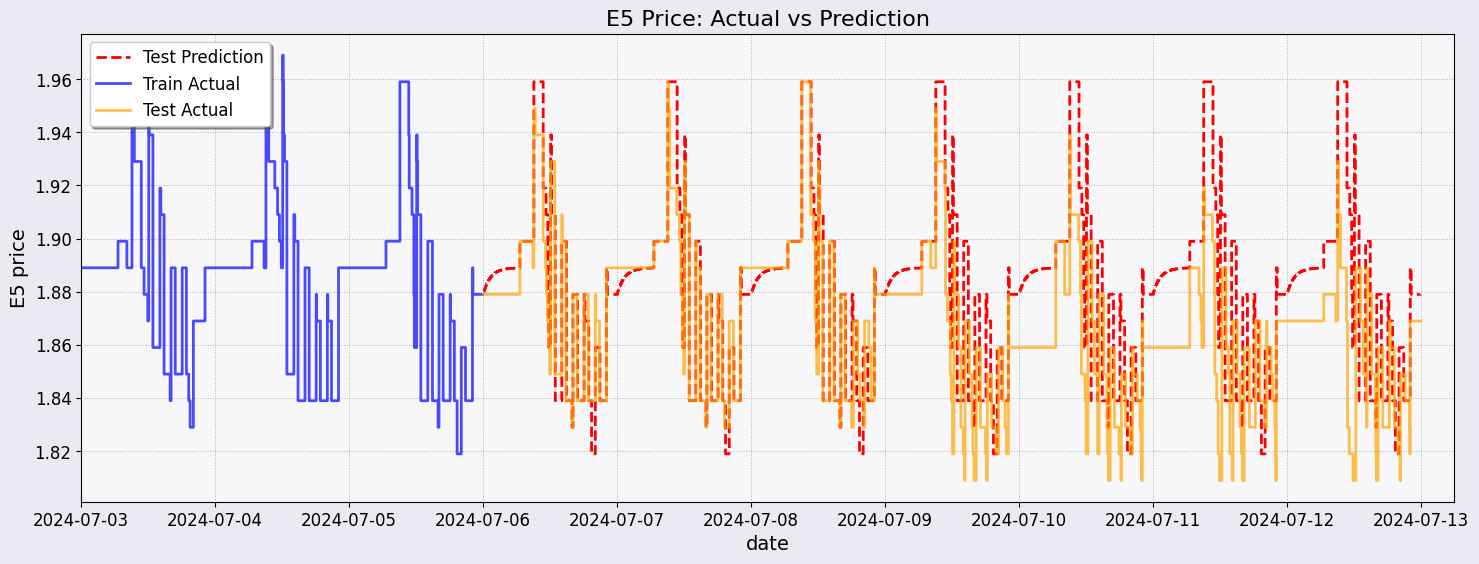

Successfully processed df09

Processing dataset: df10
Fitting SARIMA model with order=(1, 0, 0) and seasonal_order=(0, 1, 0, 144)...
1-Day MAE in cent: 1.5289
1-Day RMSE in cent: 2.3696
1-Day r2-score: 0.2666
3-Day MAE in cent: 1.3916
3-Day RMSE in cent: 2.1570
3-Day r2-score: 0.1863
7-Day MAE in cent: 1.2657
7-Day RMSE in cent: 2.0669
7-Day r2-score: 0.3399


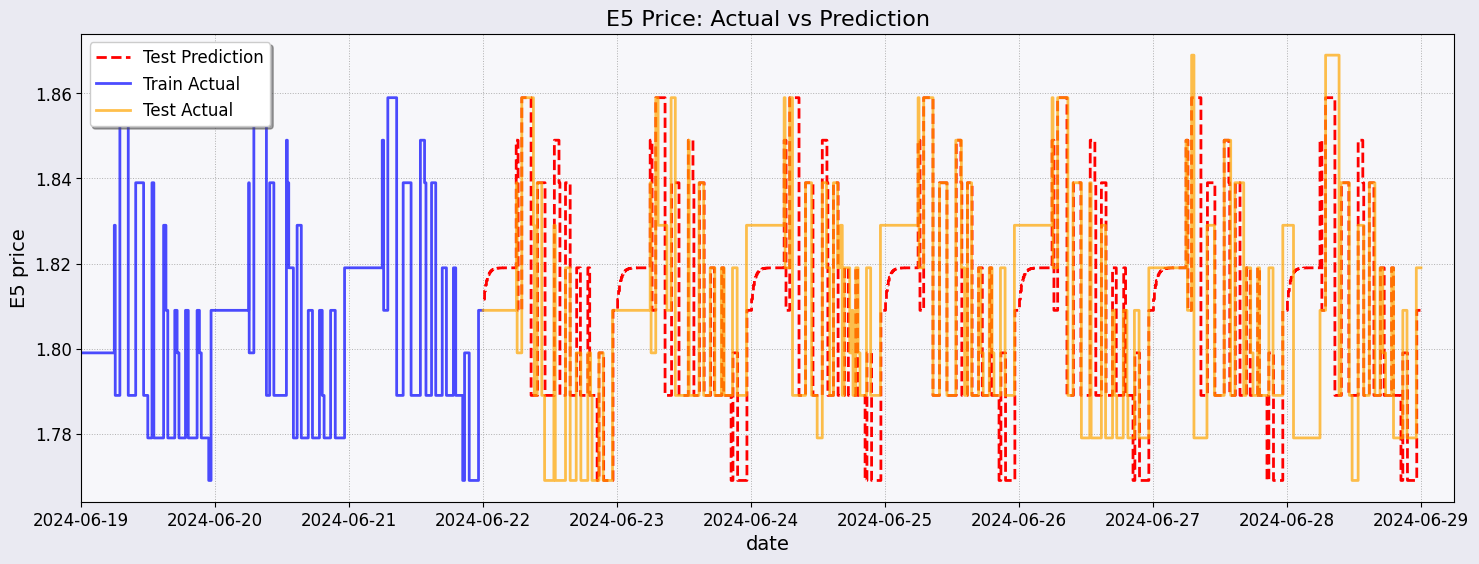

Successfully processed df10

Processing dataset: df11
Fitting SARIMA model with order=(1, 0, 0) and seasonal_order=(0, 1, 0, 144)...
1-Day MAE in cent: 1.8640
1-Day RMSE in cent: 2.7883
1-Day r2-score: 0.4689
3-Day MAE in cent: 2.0862
3-Day RMSE in cent: 2.9991
3-Day r2-score: 0.2385
7-Day MAE in cent: 2.5635
7-Day RMSE in cent: 3.4363
7-Day r2-score: 0.4631


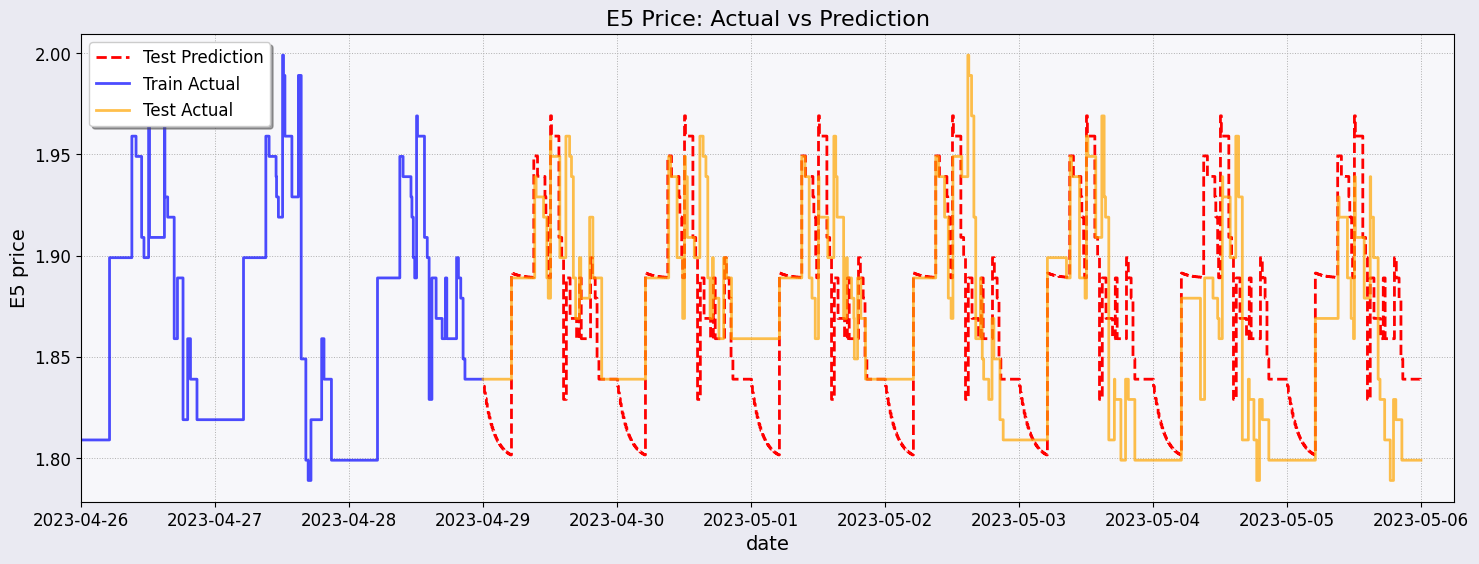

Successfully processed df11

Processing dataset: df12
Fitting SARIMA model with order=(1, 0, 0) and seasonal_order=(0, 1, 0, 144)...
1-Day MAE in cent: 0.7227
1-Day RMSE in cent: 1.1159
1-Day r2-score: 0.9102
3-Day MAE in cent: 1.0237
3-Day RMSE in cent: 1.4735
3-Day r2-score: 0.8320
7-Day MAE in cent: 1.3070
7-Day RMSE in cent: 1.7181
7-Day r2-score: 0.7114


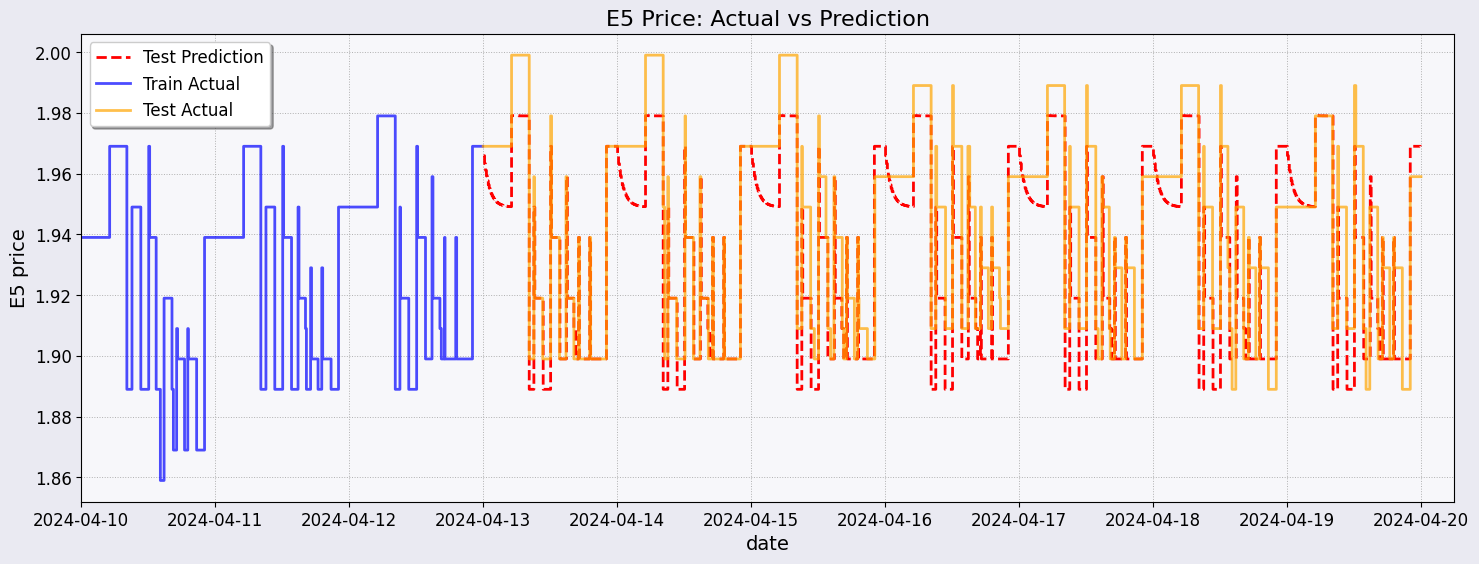

Successfully processed df12

Processing dataset: df13
Fitting SARIMA model with order=(1, 0, 0) and seasonal_order=(0, 1, 0, 144)...
1-Day MAE in cent: 2.2048
1-Day RMSE in cent: 3.2431
1-Day r2-score: -0.0774
3-Day MAE in cent: 1.6978
3-Day RMSE in cent: 2.6046
3-Day r2-score: 0.2774
7-Day MAE in cent: 1.6214
7-Day RMSE in cent: 2.4395
7-Day r2-score: 0.4717


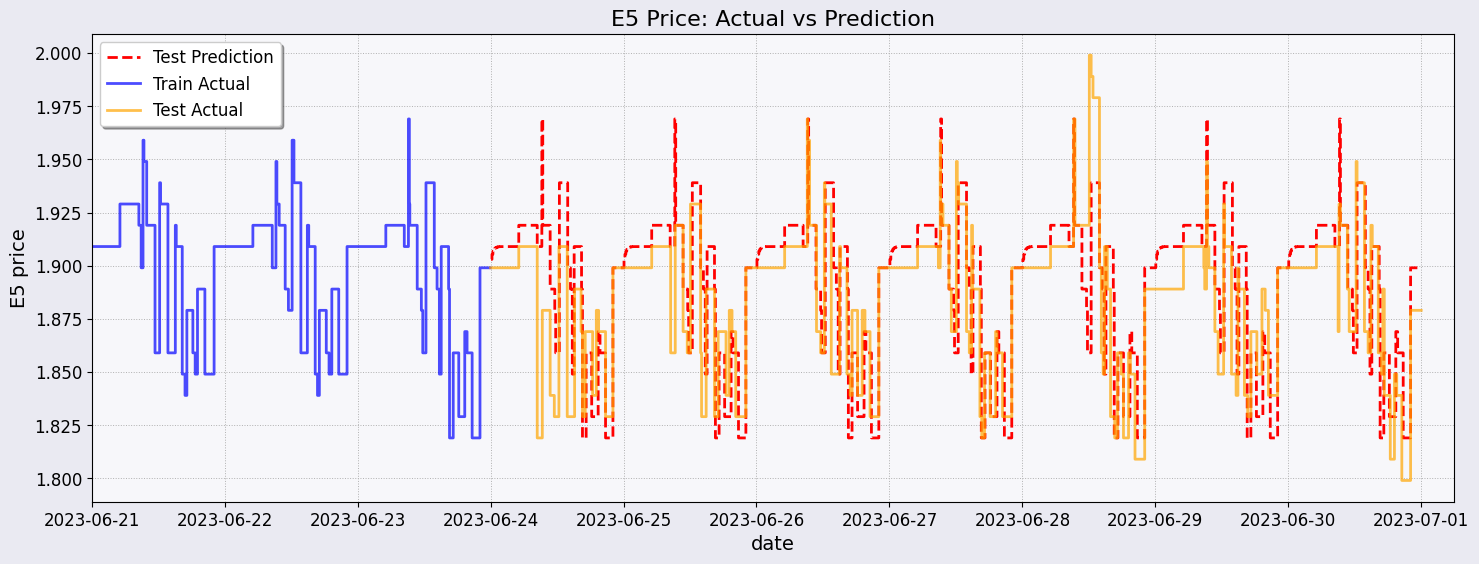

Successfully processed df13

Processing dataset: df14
Fitting SARIMA model with order=(1, 0, 0) and seasonal_order=(0, 1, 0, 144)...
1-Day MAE in cent: 3.0417
1-Day RMSE in cent: 4.0329
1-Day r2-score: -0.4687
3-Day MAE in cent: 3.0116
3-Day RMSE in cent: 3.7966
3-Day r2-score: -0.3200
7-Day MAE in cent: 3.6964
7-Day RMSE in cent: 4.3852
7-Day r2-score: -0.4471


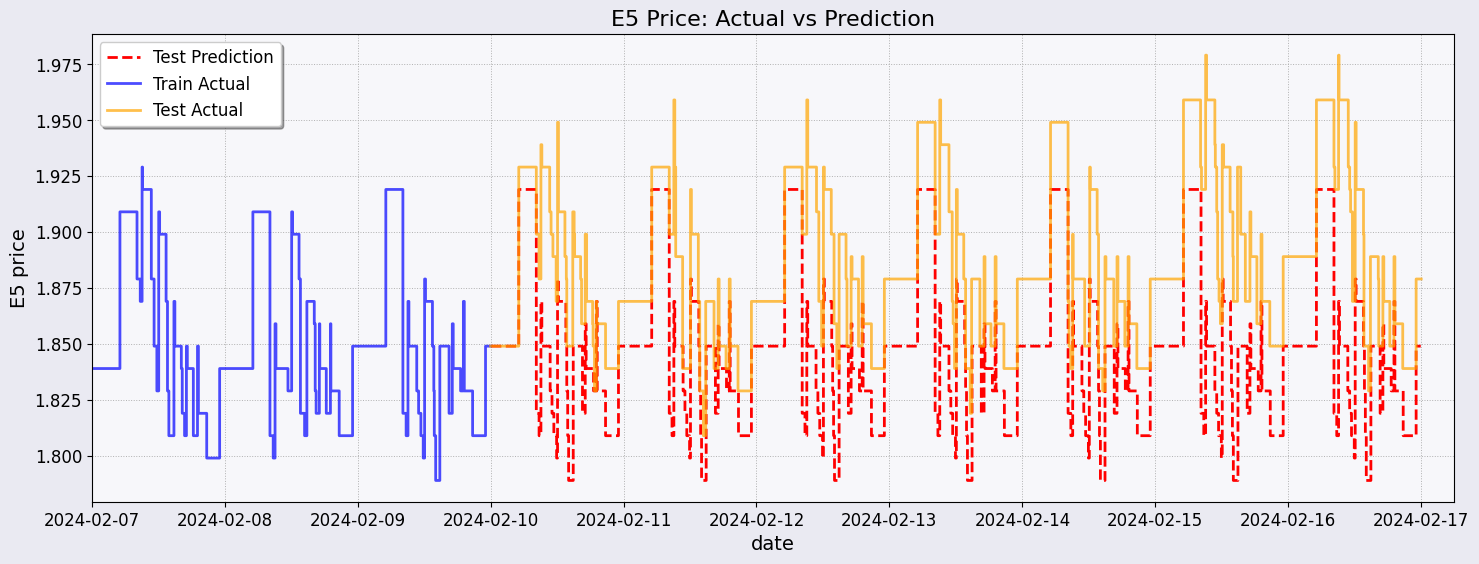

Successfully processed df14

Processing dataset: df15
Fitting SARIMA model with order=(1, 0, 0) and seasonal_order=(0, 1, 0, 144)...
1-Day MAE in cent: 1.6042
1-Day RMSE in cent: 2.4310
1-Day r2-score: 0.5644
3-Day MAE in cent: 2.1389
3-Day RMSE in cent: 3.0769
3-Day r2-score: 0.5313
7-Day MAE in cent: 1.7262
7-Day RMSE in cent: 2.4648
7-Day r2-score: 0.6534


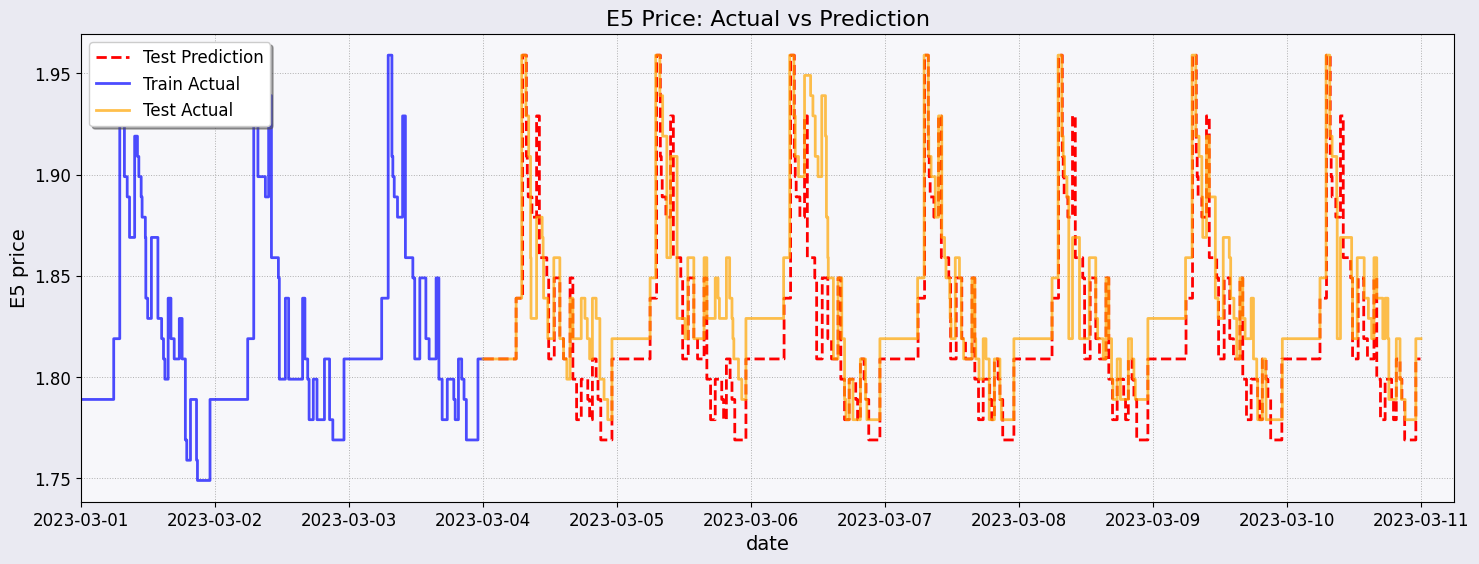

Successfully processed df15

Processing dataset: df16
Fitting SARIMA model with order=(1, 0, 0) and seasonal_order=(0, 1, 0, 144)...
1-Day MAE in cent: 1.7840
1-Day RMSE in cent: 2.3385
1-Day r2-score: 0.4061
3-Day MAE in cent: 1.5395
3-Day RMSE in cent: 2.1240
3-Day r2-score: 0.5468
7-Day MAE in cent: 1.3888
7-Day RMSE in cent: 2.0530
7-Day r2-score: 0.5845


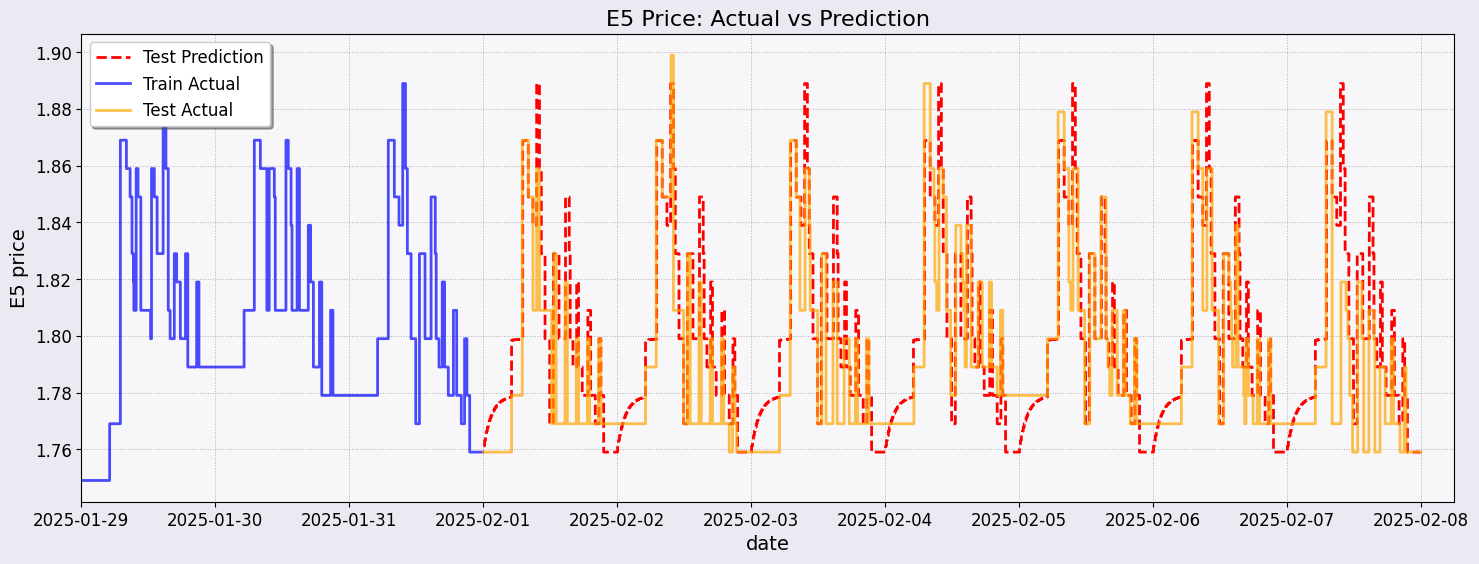

Successfully processed df16

Processing dataset: df17
Fitting SARIMA model with order=(1, 0, 0) and seasonal_order=(0, 1, 0, 144)...
1-Day MAE in cent: 1.0208
1-Day RMSE in cent: 2.0052
1-Day r2-score: 0.7980
3-Day MAE in cent: 1.2685
3-Day RMSE in cent: 1.9496
3-Day r2-score: 0.8078
7-Day MAE in cent: 1.3532
7-Day RMSE in cent: 2.3223
7-Day r2-score: 0.7321


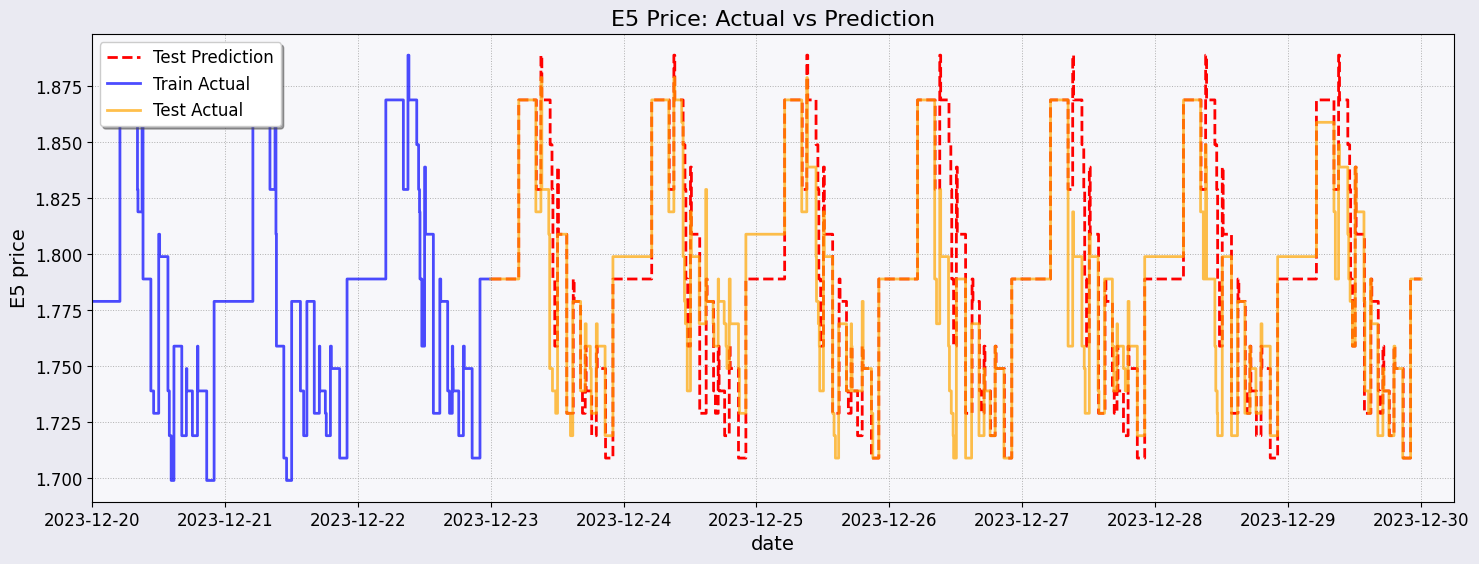

Successfully processed df17

Processing dataset: df18
Fitting SARIMA model with order=(1, 0, 0) and seasonal_order=(0, 1, 0, 144)...
1-Day MAE in cent: 1.2569
1-Day RMSE in cent: 1.7017
1-Day r2-score: 0.7240
3-Day MAE in cent: 1.5301
3-Day RMSE in cent: 2.0213
3-Day r2-score: 0.6414
7-Day MAE in cent: 1.7312
7-Day RMSE in cent: 2.3484
7-Day r2-score: 0.5919


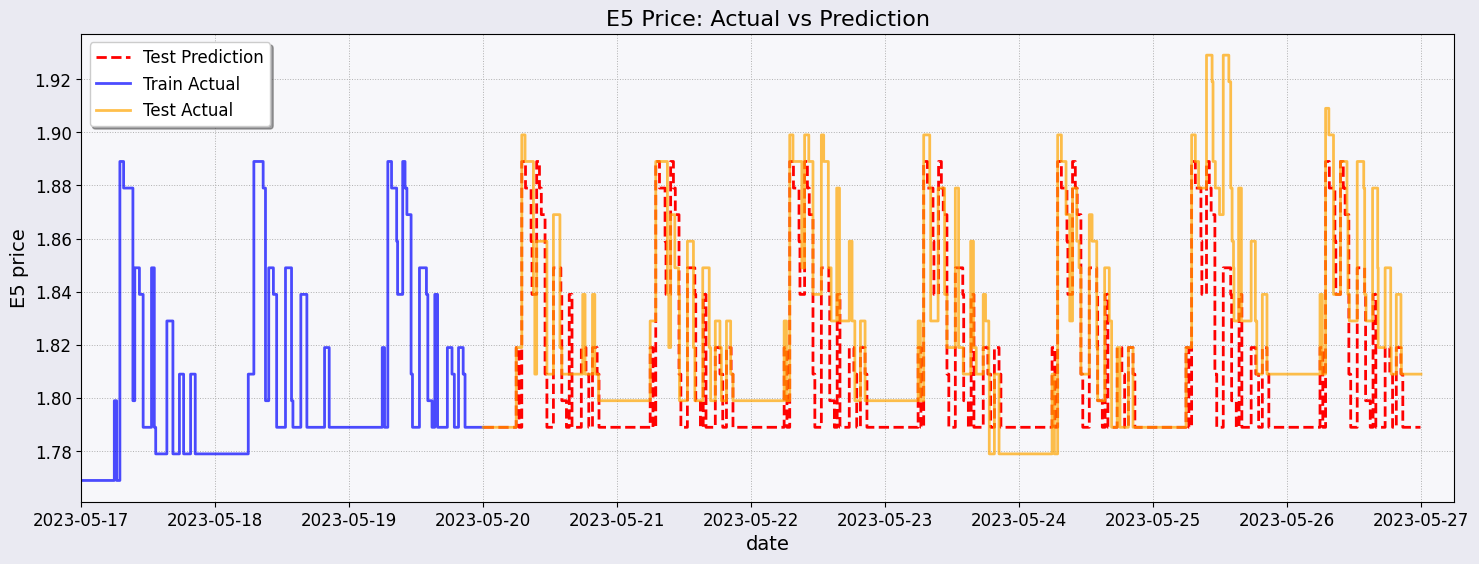

Successfully processed df18

Processing dataset: df19
Fitting SARIMA model with order=(1, 0, 0) and seasonal_order=(0, 1, 0, 144)...
1-Day MAE in cent: 1.0998
1-Day RMSE in cent: 1.2729
1-Day r2-score: -6.6361
3-Day MAE in cent: 1.4191
3-Day RMSE in cent: 1.5016
3-Day r2-score: -23.6484
7-Day MAE in cent: 1.0823
7-Day RMSE in cent: 1.2403
7-Day r2-score: -1.9443


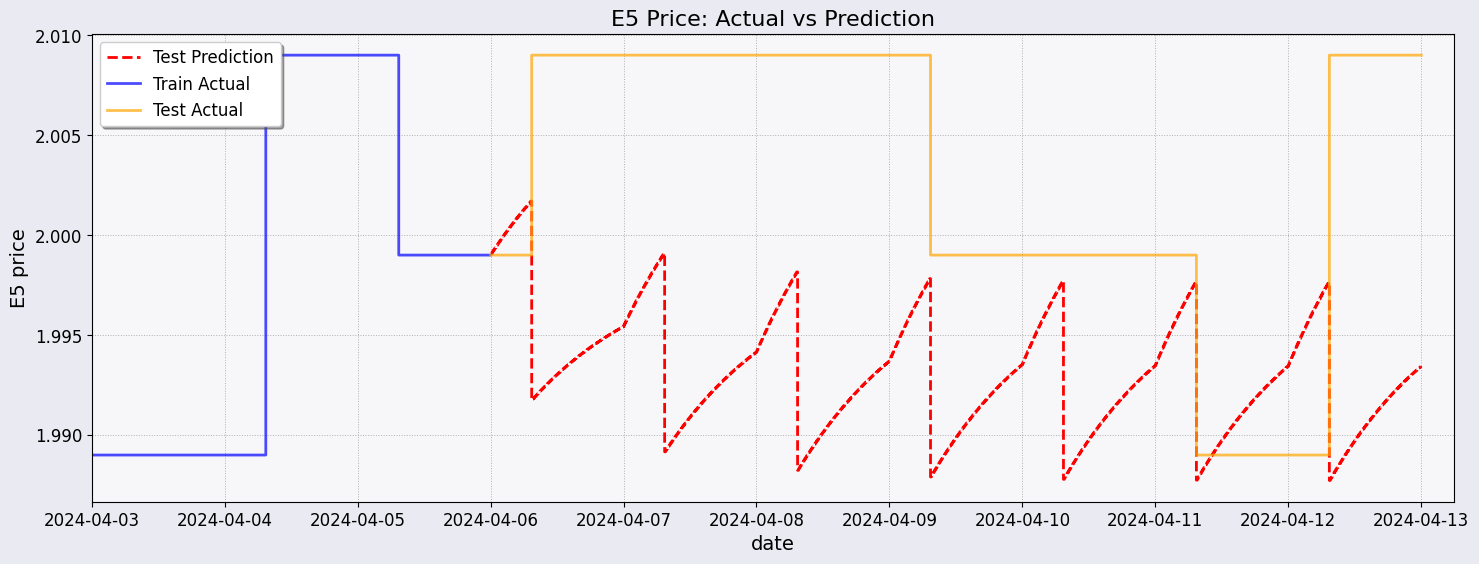

Successfully processed df19

Processing dataset: df20
Fitting SARIMA model with order=(1, 0, 0) and seasonal_order=(0, 1, 0, 144)...
1-Day MAE in cent: 0.0000
1-Day RMSE in cent: 0.0000
1-Day r2-score: 1.0000
3-Day MAE in cent: 0.0000
3-Day RMSE in cent: 0.0000
3-Day r2-score: 1.0000
7-Day MAE in cent: 0.0000
7-Day RMSE in cent: 0.0000
7-Day r2-score: 1.0000


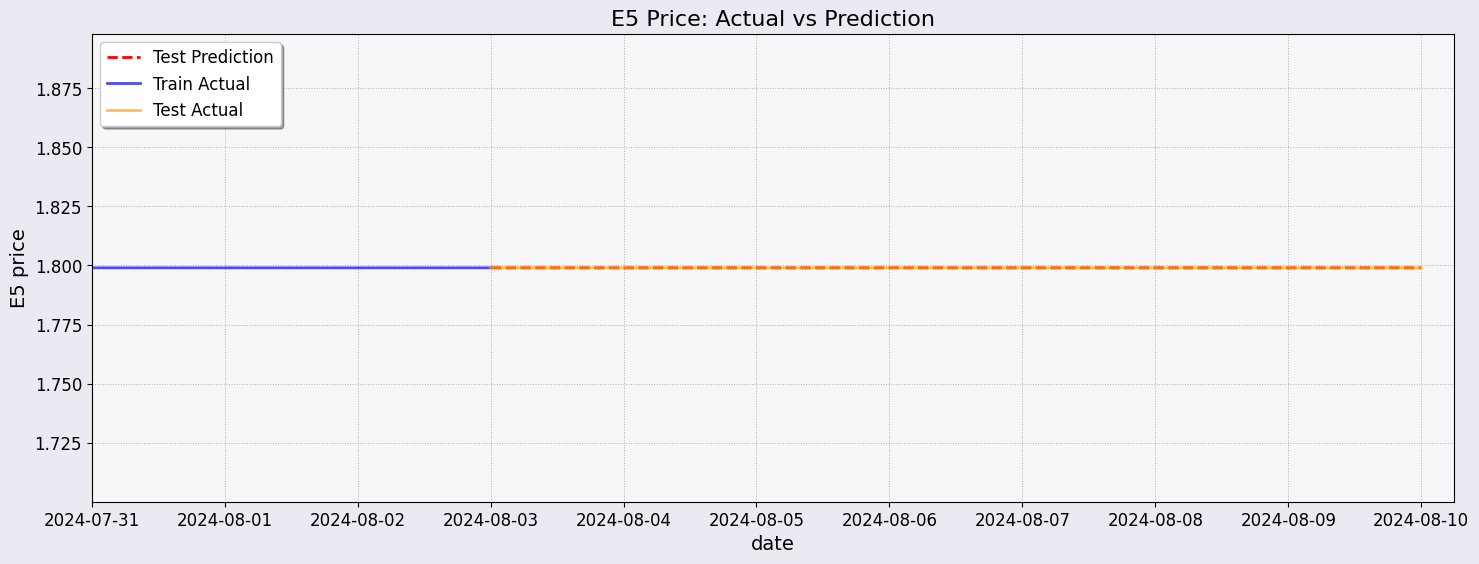

Successfully processed df20

Processing dataset: df21
Fitting SARIMA model with order=(1, 0, 0) and seasonal_order=(0, 1, 0, 144)...
1-Day MAE in cent: 1.2986
1-Day RMSE in cent: 1.8238
1-Day r2-score: 0.2718
3-Day MAE in cent: 1.3495
3-Day RMSE in cent: 1.7193
3-Day r2-score: 0.2380
7-Day MAE in cent: 1.3204
7-Day RMSE in cent: 1.6824
7-Day r2-score: 0.3123


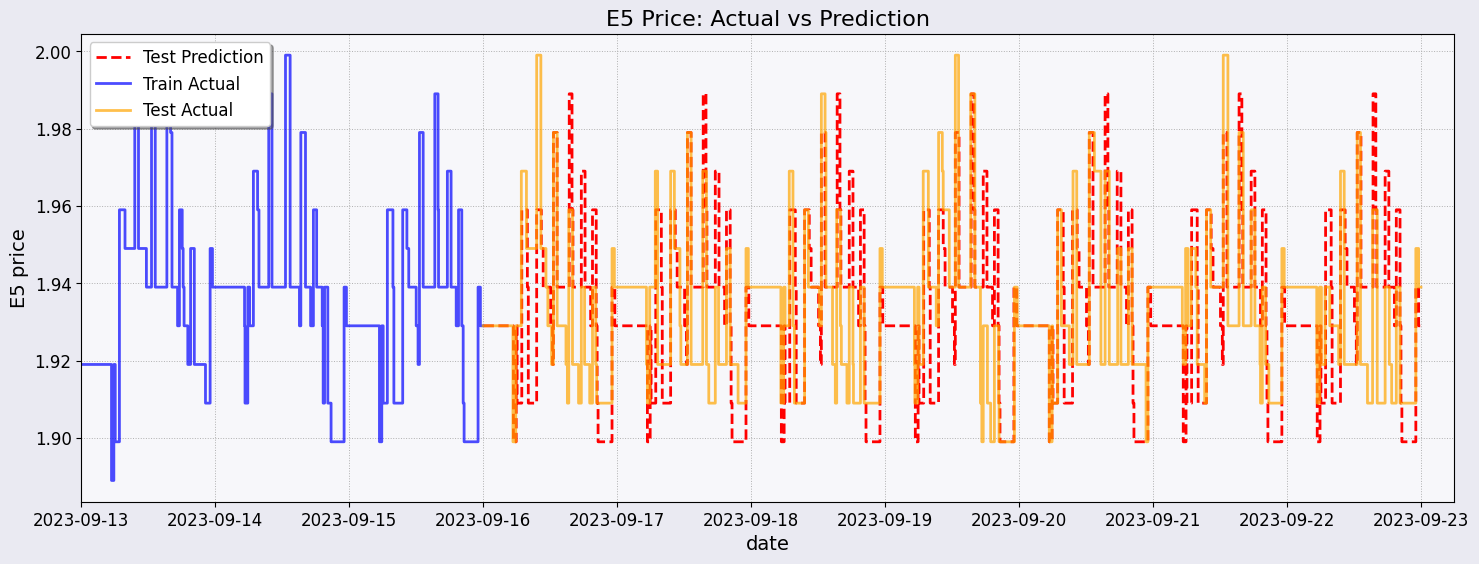

Successfully processed df21

Processing dataset: df22
Fitting SARIMA model with order=(1, 0, 0) and seasonal_order=(0, 1, 0, 144)...
1-Day MAE in cent: 1.4971
1-Day RMSE in cent: 1.8095
1-Day r2-score: 0.4972
3-Day MAE in cent: 1.9230
3-Day RMSE in cent: 2.4230
3-Day r2-score: 0.2388
7-Day MAE in cent: 1.8661
7-Day RMSE in cent: 2.3050
7-Day r2-score: 0.4260


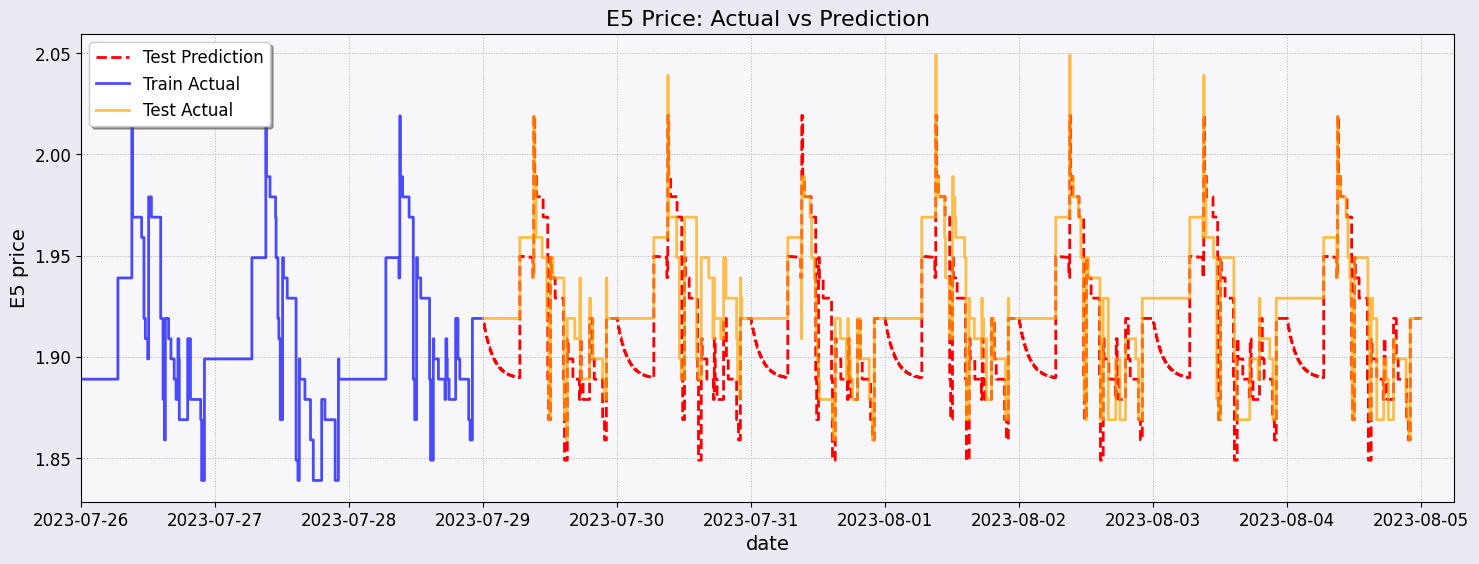

Successfully processed df22

Processing dataset: df23
Fitting SARIMA model with order=(1, 0, 0) and seasonal_order=(0, 1, 0, 144)...
1-Day MAE in cent: 1.1108
1-Day RMSE in cent: 1.7990
1-Day r2-score: 0.6423
3-Day MAE in cent: 1.1525
3-Day RMSE in cent: 1.7295
3-Day r2-score: 0.6423
7-Day MAE in cent: 1.4907
7-Day RMSE in cent: 2.0205
7-Day r2-score: 0.5133


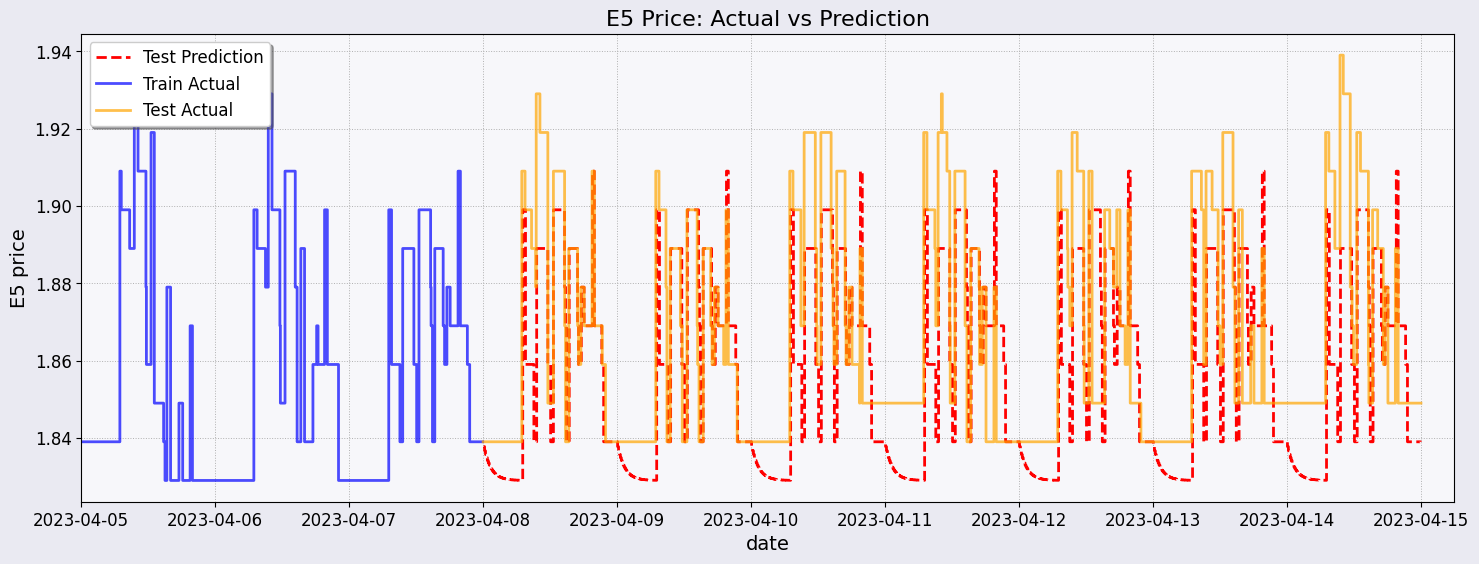

Successfully processed df23

Processing dataset: df24
Fitting SARIMA model with order=(1, 0, 0) and seasonal_order=(0, 1, 0, 144)...
1-Day MAE in cent: 2.4960
1-Day RMSE in cent: 4.1134
1-Day r2-score: -0.0285
3-Day MAE in cent: 1.6513
3-Day RMSE in cent: 2.7076
3-Day r2-score: 0.6307
7-Day MAE in cent: 3.1822
7-Day RMSE in cent: 4.2625
7-Day r2-score: 0.3111


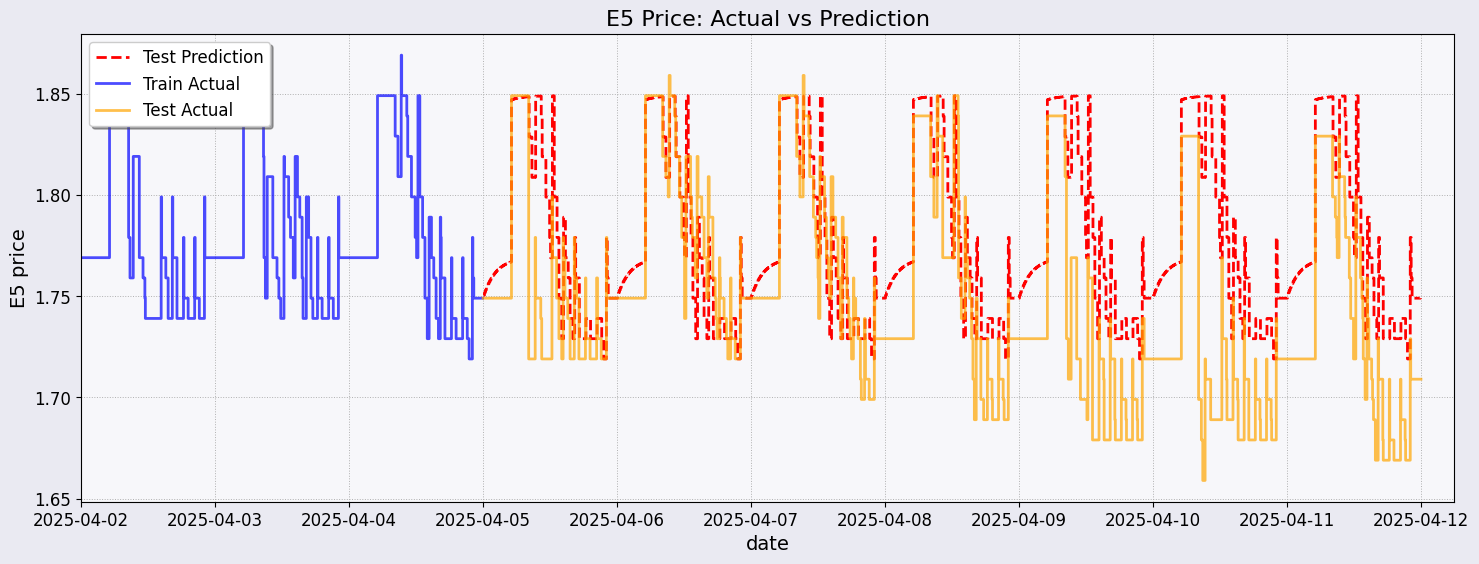

Successfully processed df24

Processing dataset: df25
Fitting SARIMA model with order=(1, 0, 0) and seasonal_order=(0, 1, 0, 144)...
1-Day MAE in cent: 1.1130
1-Day RMSE in cent: 1.4120
1-Day r2-score: 0.7412
3-Day MAE in cent: 1.4371
3-Day RMSE in cent: 1.7642
3-Day r2-score: 0.6672
7-Day MAE in cent: 1.6487
7-Day RMSE in cent: 2.0024
7-Day r2-score: 0.5532


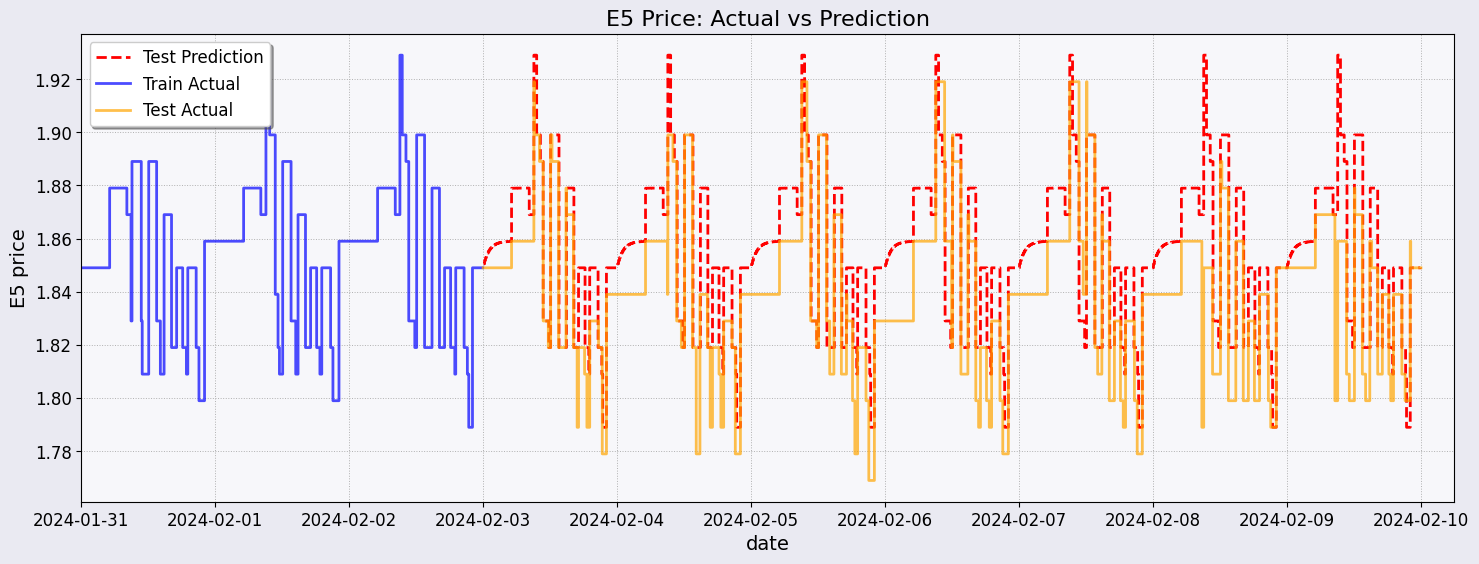

Successfully processed df25

Processing dataset: df26
Fitting SARIMA model with order=(1, 0, 0) and seasonal_order=(0, 1, 0, 144)...
1-Day MAE in cent: 2.1792
1-Day RMSE in cent: 2.7353
1-Day r2-score: 0.6234
3-Day MAE in cent: 2.1468
3-Day RMSE in cent: 2.6737
3-Day r2-score: 0.6431
7-Day MAE in cent: 2.4669
7-Day RMSE in cent: 3.0690
7-Day r2-score: 0.5030


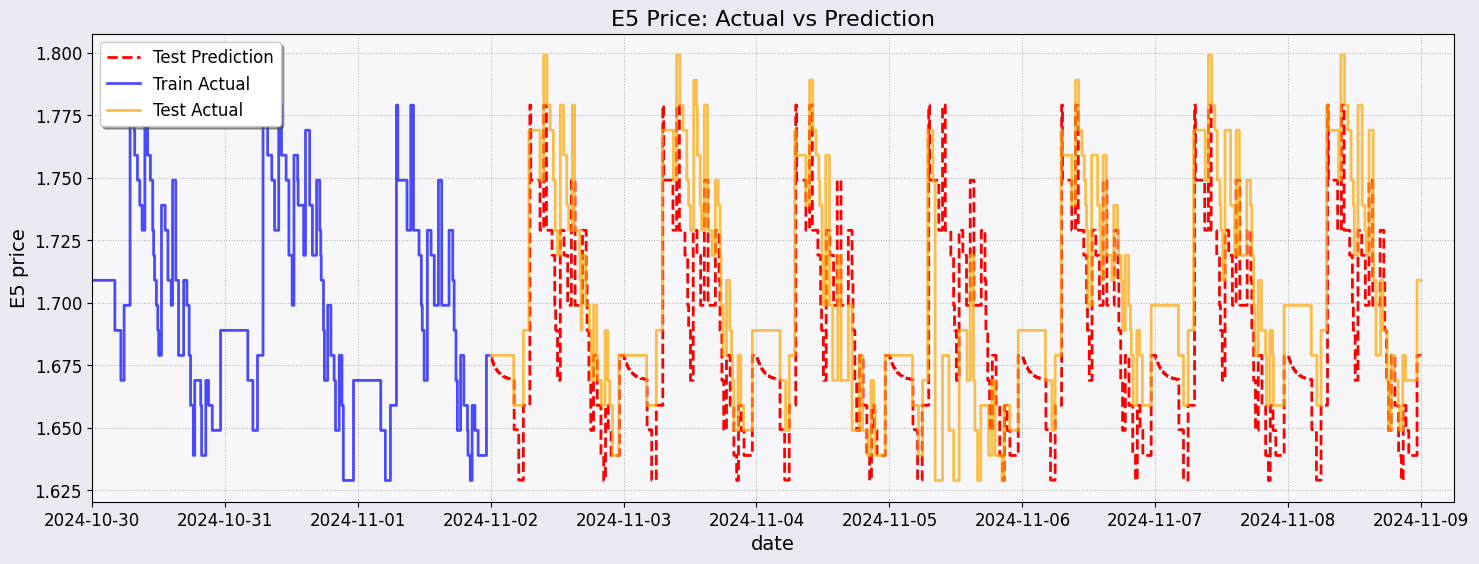

Successfully processed df26

Processing dataset: df27
Fitting SARIMA model with order=(1, 0, 0) and seasonal_order=(0, 1, 0, 144)...
1-Day MAE in cent: 1.3656
1-Day RMSE in cent: 2.3574
1-Day r2-score: 0.5481
3-Day MAE in cent: 1.9882
3-Day RMSE in cent: 3.0226
3-Day r2-score: 0.3882
7-Day MAE in cent: 2.8218
7-Day RMSE in cent: 3.7697
7-Day r2-score: 0.3133


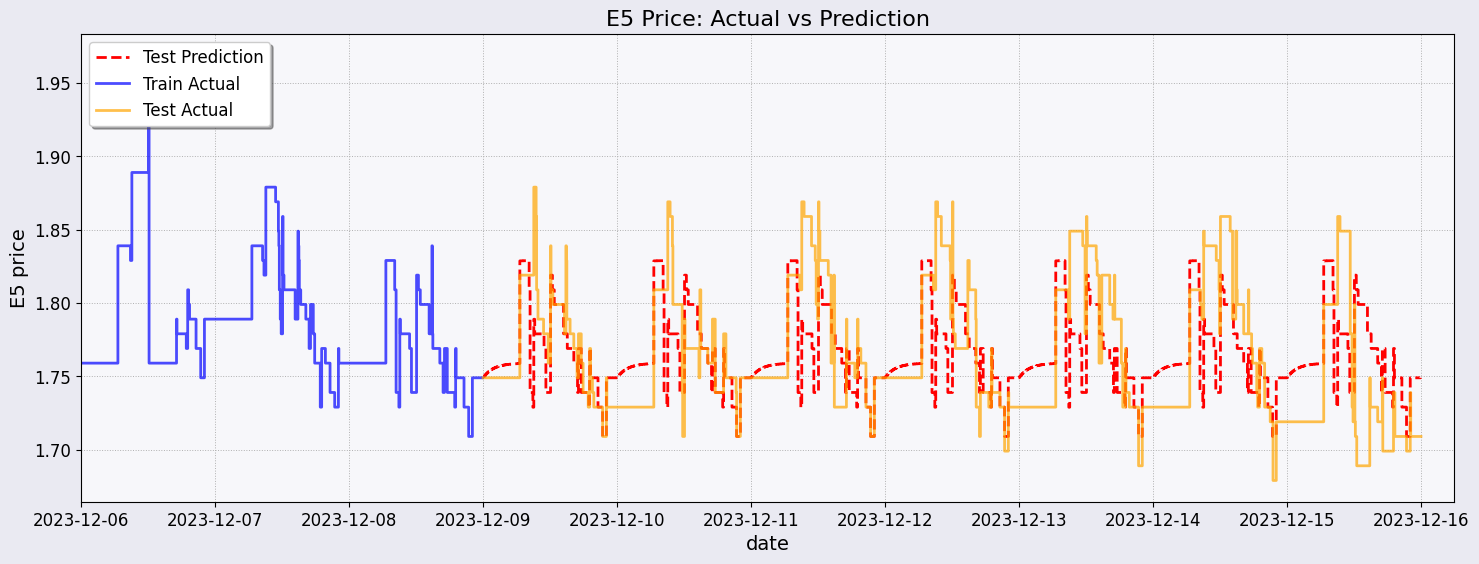

Successfully processed df27

Processing dataset: df28
Fitting SARIMA model with order=(1, 0, 0) and seasonal_order=(0, 1, 0, 144)...
1-Day MAE in cent: 0.9931
1-Day RMSE in cent: 1.4743
1-Day r2-score: 0.7862
3-Day MAE in cent: 1.4398
3-Day RMSE in cent: 1.9814
3-Day r2-score: 0.6023
7-Day MAE in cent: 1.8899
7-Day RMSE in cent: 2.4224
7-Day r2-score: 0.5797


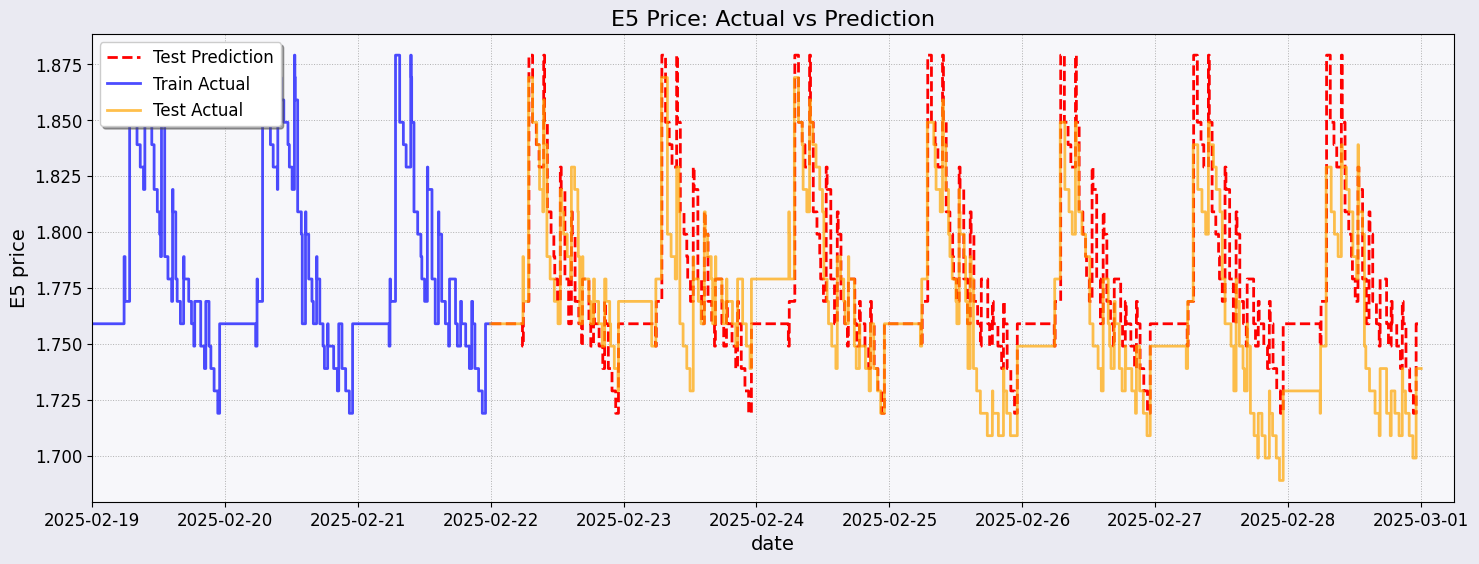

Successfully processed df28

Processing dataset: df29
Fitting SARIMA model with order=(1, 0, 0) and seasonal_order=(0, 1, 0, 144)...
1-Day MAE in cent: 0.0000
1-Day RMSE in cent: 0.0000
1-Day r2-score: 1.0000
3-Day MAE in cent: 0.0000
3-Day RMSE in cent: 0.0000
3-Day r2-score: 1.0000
7-Day MAE in cent: 0.0000
7-Day RMSE in cent: 0.0000
7-Day r2-score: 1.0000


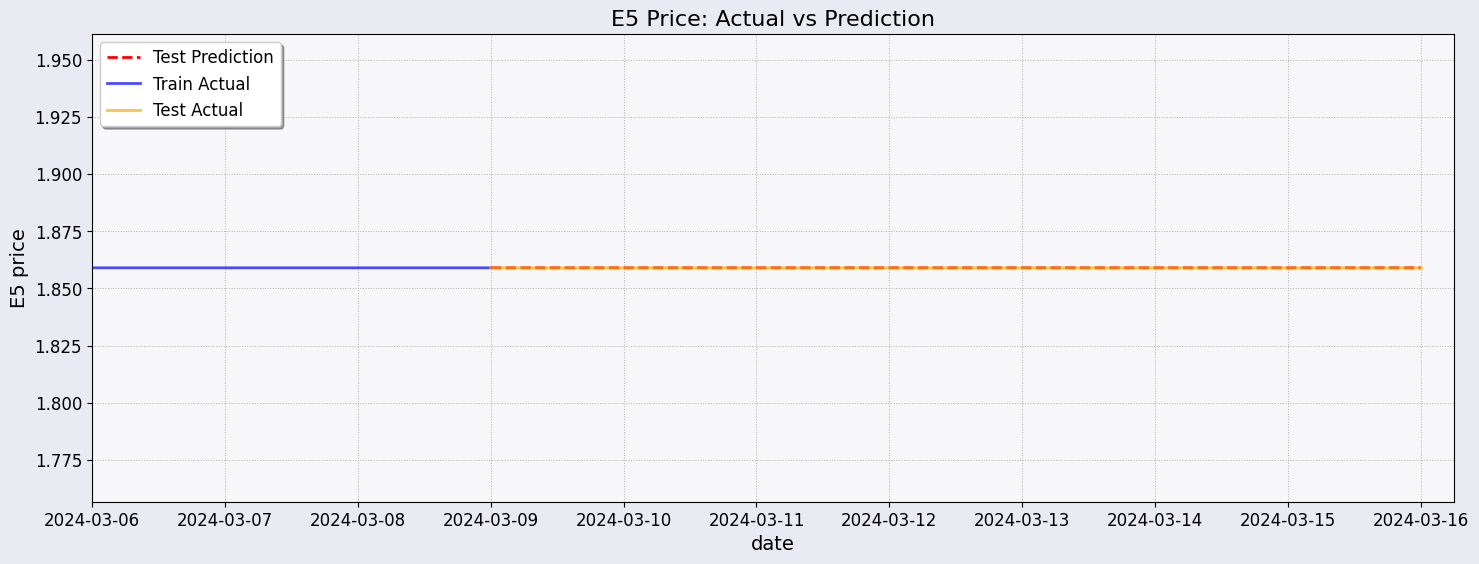

Successfully processed df29

Processing dataset: df30
Fitting SARIMA model with order=(1, 0, 0) and seasonal_order=(0, 1, 0, 144)...
1-Day MAE in cent: 0.6920
1-Day RMSE in cent: 1.1371
1-Day r2-score: 0.8294
3-Day MAE in cent: 1.2537
3-Day RMSE in cent: 1.8547
3-Day r2-score: 0.6001
7-Day MAE in cent: 2.6078
7-Day RMSE in cent: 3.5133
7-Day r2-score: -0.0259


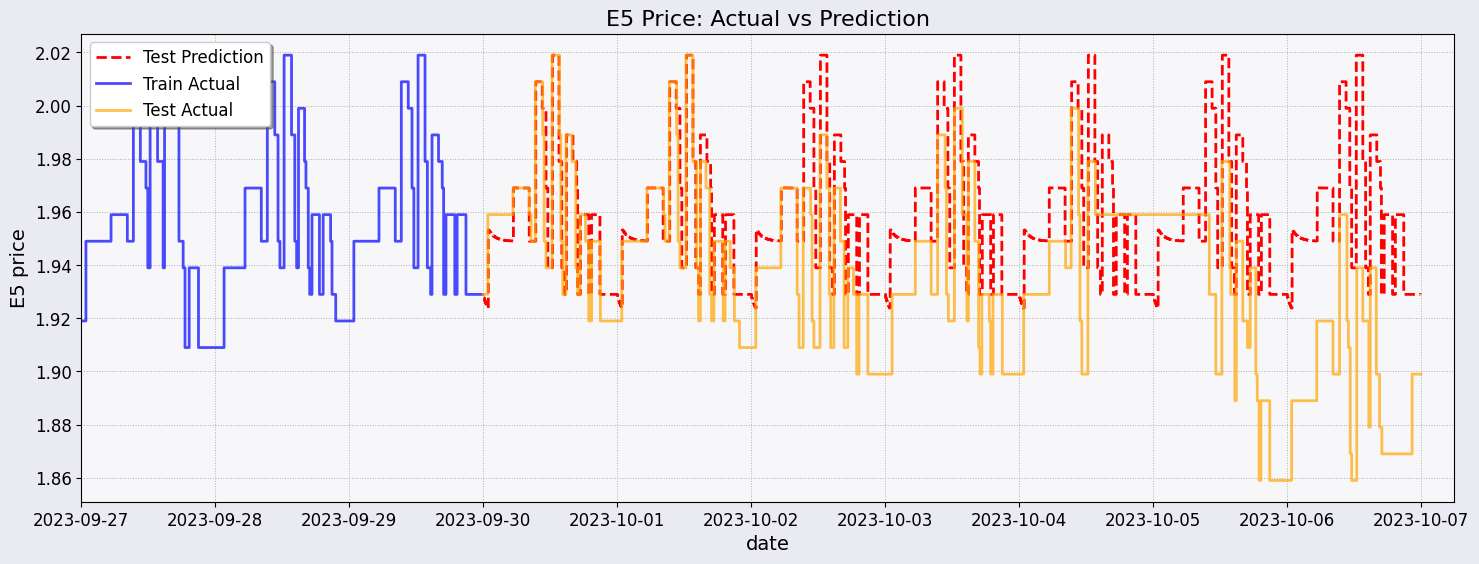

Successfully processed df30

=== Error Summary ===
All datasets processed successfully!


In [6]:
forecast_days = 7 # how many days should be forecasted
train_days = 14 # how many days will be used to train on
sampling_rate = 10 #in minutes, very important parameter. For 5 minutes very slow, and does not add much of acc

# Create an error log dictionary
error_log = {}

# LOOP
for dataset_name, (df_train, df_test) in datasets.items():
    print(f"\nProcessing dataset: {dataset_name}")

    try:
        mlflow.end_run()

        with mlflow.start_run(run_name=f"fuel_model_Anton_SARIMA_{dataset_name}") as run:
            mlflow.set_tag("dataset", f'{dataset_name}')


            train_start = pd.to_datetime(df_train['date'].iloc[-1]) - pd.Timedelta(days = train_days)
            train_end = pd.to_datetime(df_train['date'].iloc[-1])
            # The forecast starts immediately after the training data ends
            forecast_start_date = train_end + pd.Timedelta(minutes=sampling_rate)
            # The forecast extends for 'forecast_days' from its start
            forecast_end_date = forecast_start_date + pd.Timedelta(days=forecast_days) - pd.Timedelta(minutes=sampling_rate)

            df_sarima = df_train[(df_train['date'] >= train_start) & (df_train['date'] <= train_end) ]

            #can be comment out in case no regressor: is_open needed

            df_sarima['hour'] = df_sarima['date'].dt.hour
            df_sarima['dayofweek'] = df_sarima['date'].dt.dayofweek

            plateau_hours_by_weekday = find_dominant_stable_hours(df_sarima)
            # --- Create the new binary column 'is_open' efficiently ---
            df_sarima['is_open'] = 1 # Default to 1 (open) for all rows

            conditions = []
            choices = []
            #find_dominant_stable_hours
            for day_of_week_idx, (plateau_start_h, plateau_end_h) in plateau_hours_by_weekday.items():
                # Only apply a 'closed' mask if a plateau was actually detected for this day
                if plateau_start_h is not None and plateau_end_h is not None:
                    mask_day = (df_sarima['dayofweek'] == day_of_week_idx)

                    if plateau_start_h < plateau_end_h: 
                        mask_hours_in_plateau = (df_sarima['hour'] >= plateau_start_h) & (df_sarima['hour'] < plateau_end_h)
                    else: # Plateau wraps around midnight
                        mask_hours_in_plateau = (df_sarima['hour'] >= plateau_start_h) | (df_sarima['hour'] < plateau_end_h)

                    conditions.append(mask_day & mask_hours_in_plateau)
                    choices.append(0) # Assign 0 (closed) for these periods

            # Apply all conditions using np.select. Rows not covered by conditions will remain '1' (open).
            df_sarima['is_open'] = np.select(conditions, choices, default=1) 

            df_sarima = df_sarima.drop(columns=['hour', 'dayofweek']) 

            # block required to resample the data to the desired frequency
            #speeds up SARIMA(X) enormously
            #df_sarima = df_train[(df_train['date'] >= train_start) & (df_train['date'] <= train_end) ]
            df_sarima.set_index('date', inplace = True)
            df_sarima.sort_index(inplace = True)
            df_sarima = df_sarima.asfreq(f'{sampling_rate}T')
            df_sarima = df_sarima.asfreq(pd.infer_freq(df_sarima.index)) # the infer_freq function will automatically detect the frequency of the time series data

            # after analyzing the ACF and PACF Plots we found out how to set our parameters for the SARIMA model
            s = int(1440/sampling_rate) # seasonality of the SarimA

            order = (1, 0, 0) # p=1, d=1, q=1           # should be set to 0, otherwise downhill trend
            seasonal_order = (0, 1, 0, s) # P=0, D=1, Q=1, s=288

            # SARIMA model itself
            print(f"Fitting SARIMA model with order={order} and seasonal_order={seasonal_order}...")
            sarima_model = SARIMAX(endog = df_sarima['e5'],
                                   exdog = df_sarima['is_open'],
                                    order=order,
                                    seasonal_order=seasonal_order,
                                    trend= None, #trend='c', trend='t'
                                    enforce_stationarity=False, # Often keep False for initial fitting
                                    enforce_invertibility=False, # Often keep False for initial fitting
                                    disp=True) # displays the progress of the fitting

            sarima_model_fit = sarima_model.fit(disp=False)
            #print(sarima_model_fit.summary())

            # Forecasting

            forecast = sarima_model_fit.predict(start = train_start, end = forecast_end_date)
            #use get prediction to add the future regressor values
            forecast = forecast.to_frame(name="e5")
            forecast = forecast.reset_index().rename(columns={'index': 'date'})

            # Plotting
            train_plot_start = pd.to_datetime(df_train['date'].iloc[-1]) - pd.Timedelta(days = 2)
            train_plot_end = pd.to_datetime(df_train['date'].iloc[-1]) + pd.Timedelta(days = 1)

            train_dates_plot = (train_plot_start.strftime('%Y-%m-%d'), train_plot_end.strftime('%Y-%m-%d'))
            test_dates_plot = (forecast_start_date.strftime('%Y-%m-%d'), pd.to_datetime(forecast_end_date.strftime('%Y-%m-%d'))+ pd.Timedelta(days = 1.25))

            mae_1_day, mae_3_day, mae_7_day, rmse_1_day, rmse_3_day, rmse_7_day, r2_1_day, r2_3_day, r2_7_day = plot_forecast(
                df_train, 
                df_test, 
                None, 
                forecast, 
                forecast, 
                train_dates_plot,
                test_dates_plot,
                train_dates_plot,
                test_dates_plot
                )

            mlflow.log_metrics({
                "mae_1_day": mae_1_day,
                "mae_3_day": mae_3_day,
                "mae_7_day": mae_7_day,
                "rmse_1_day": rmse_1_day,
                "rmse_3_day": rmse_3_day,
                "rmse_7_day": rmse_7_day,
                "r2_1_day": r2_1_day,
                "r2_3_day": r2_3_day,
                "r2_7_day": r2_7_day
                })


            print(f"Successfully processed {dataset_name}")

    except Exception as e:
                # Log the error and continue with next dataset
            error_message = f"Error in {dataset_name}: {str(e)}"
            error_log[dataset_name] = error_message
            print(error_message)

            # Make sure to end the MLflow run if it failed
            mlflow.end_run()
            continue


# After the loop, print summary of errors
print("\n=== Error Summary ===")
if error_log:
    print(f"Total errors: {len(error_log)}")
    for dataset, error in error_log.items():
        print(f"\n{dataset}:")
        print(error)
else:
    print("All datasets processed successfully!")

In [7]:
mlflow.end_run()

In [8]:
#Check data:

%mlflow ui --backend-store-uri file:data/mlflow

UsageError: Line magic function `%mlflow` not found.
